In [16]:
dataset_name = "W19_comb"
df_list = [ "BES_Panel", "BES_reduced_with_na"]

In [18]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

%matplotlib inline

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re

sns.set();
sns.set_palette("colorblind")

from IPython.display import display, display_html, HTML
from IPython.core.debugger import set_trace
# plt.rcParams["axes.grid"] = False

import Jupyter_module_loader
from utility import *
import gaussian_kde

import warnings
warnings.filterwarnings('ignore')

import holoviews as hv
from holoviews import opts

encoding = "ISO-8859-1"

# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
# %matplotlib inline
(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()

global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_pickle(data_subfolder + dataset_filename.replace('.dta','.zip'),compression='zip')
    else:
        globals()[df]  = pd.read_pickle(data_subfolder + df + '.zip',compression='zip' )
        globals()[df].replace(-1,np.nan,inplace=True)
  
(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

# get full set of inferred "cross wave" auth-lib/left-right values and ages
pan_dataset_allr_values = pd.read_csv(BES_small_data_files + "pan_dataset_allr_values"+".csv")
pan_dataset_ages = pd.read_csv( BES_small_data_files + "pan_dataset_ages"+".csv" )
pan_dataset_votes = pd.read_pickle(BES_small_data_files + "pan_dataset_votes"+".zip", compression='zip')

Toggle code

var_type (7911, 14)


In [182]:
# pan_dataset_votes = pd.read_pickle(BES_small_data_files + "pan_dataset_votes"+".zip", compression='zip')

In [31]:
# array(['Plaid Cymru', 'British National Party (BNP)', 'Labour',
#        'Brexit Party', 'Leave the EU', 'Conservative',
#        'Stay/remain in the EU', 'Did not vote', 'Unknown', "Don't know",
#        'Too Young To Vote', 'United Kingdom Independence Party (UKIP)',
#        'Liberal Democrat', 'Scottish National Party', 'Other',
#        'Green Party', 'Ambiguous category',
#        'Scottish National Party (SNP)', 'Respect', 'Not Present',
#        'Veritas'], dtype=object)

In [38]:
party_colour_dict = {"Lab":"red","LAB":"red",
                     "Con":'blue',"CON":'blue',"UKIP":"purple","LD":"orange",
                     "Grn":'green',"GRN":'green',
                     "BrexitParty":"cyan","BXP":'cyan',
                     "TIG":"pink","BNP":"magenta",
                     "SNP":'yellow',"PC":'olive',
                     "Remain":"yellow","REMAIN":'yellow',"Leave":"blue","LEAVE":'blue',
                     "Don't know":"grey","DK":'grey',
                     "Won't vote":"black","DNV":'black',"NON":'black',
                     "???":'lightgrey',"<18":'pink',"?":'darkgrey',"NULL":'black',
                     }

# party_list = list( BES_Panel[ ['profile_past_vote_2005','profile_past_vote_2010','profile_past_vote_2015' ] ].stack().unique() )
# party_list.append('I would not vote')
replace_dict = {'Labour Party':"LAB", 
 'United Kingdom Independence Party (UKIP)':"UKIP",
 'Labour':"LAB",
 'Conservative Party':"CON",
 'Conservative':"CON",
 'Liberal Democrats':"LD",
 'Did not vote':"DNV",
 'Scottish National Party':"SNP",
 'Scottish National Party (SNP)':"SNP",
 'British National Party (BNP)':"BNP",
 'Green Party':"GP",
 'Green':"GP",
 'Liberal Democrat':"LD",
 "Don't know":"DK",
 'Some other party':"OTH",
 'Veritas':"VER",
 'Plaid Cymru':"PC",
 'Other':"OTH",
 'Respect':"RES",
 'I would not vote':"DNV",
 "Brexit Party":"BXP",
 'Change UK- The Independent Group':"CUK",
 "Leave the EU":"LEAVE",
 "Stay/remain in the EU":"REMAIN",
 "Not Present":"NULL",
 "Ambiguous category":"?",
 "Unknown":"???",
 "Too Young To Vote":"<18",}



colourmap = {'LAB':'red', 'UKIP':'purple', 'CON':'blue', 'SNP':'yellow', 'BNP':'black', 'LD':'orange', 'DNV':'dimgray', 'DK':'lightgray', 'OTH':'brown', 'GP':'green',
       'VER':'pink', 'PC':'olive', 'RES':'peru', "BXP":'cyan',"CUK":'black','LEAVE':'blue','REMAIN':'yellow',
       "???":'grey',"<18":'pink',"?":'grey',"NULL":'black',     }
base_order = ['LAB','CON','DK','UKIP','LD','SNP','DNV','GP','PC','BNP','OTH','RES','VER']
lr_order   = ['GP','PC','LAB','SNP','DK','OTH','DNV','LD','CON','UKIP','BNP','RES','VER']
cmap = ['red','purple','blue','yellow','black','orange','grey','cyan','brown','green','pink','olive','peru']

In [20]:
sub_treatment = "quick_value_breakdown"
output_subfolder = create_subdir(BES_output_folder, sub_treatment) 

In [21]:
def weighted_qcut(values, weights, q, **kwargs):
    if is_integer(q):
        quantiles = np.linspace(0, 1, q + 1)
    else:
        quantiles = q
#     order = weights[values.argsort()].cumsum()
    order = weights.loc[weights.index[values.argsort()]].cumsum()
    bins = pd.cut(order / order.iloc[-1], quantiles, **kwargs)
    return bins.sort_index()

def weighted_value_counts(x, wts, *args, **kwargs):
    normalize = kwargs.get('normalize', False)
    perc = kwargs.get('perc', False)
    decimal_places = kwargs.get('decimal_places', 2)
    suppress_raw_samplesize = kwargs.get('suppress_raw_samplesize', False)
    
    ascending = kwargs.get('ascending', True)
    if not x.name:
        x.name = "value"
    c0 = x.name 
    c1 = wts.name
    df = pd.concat([x,wts],axis=1)
    xtmp = df.groupby(c0).agg({c1:'sum'}).sort_values(c1,ascending=False)
    s = pd.Series(index=xtmp.index, data=xtmp[c1], name=c0)
    s.name = "weighted_sample_size"
    if normalize:
        s = s / df[c1].sum()
        s.name = "weighted_sample_fraction"
    if normalize and perc:
        s = s*100
        s.name = "weighted_sample_percentage"
    s = s.round(decimal_places)
    if decimal_places==0:
        s=s.astype('int')
        
    if not suppress_raw_samplesize:
        output = pd.DataFrame([s,x[wts.notnull()].value_counts()]).T
        output.columns = [s.name,"raw_sample_size"]
        output.index.name = x.name
        output.sort_values(by=s.name,inplace=True, ascending=ascending)
    else:
        output = s
    return output

In [22]:
# Probably_didnt_vote_list = ["Don't know","No, did not vote","No, I did not vote",2.0,99.0]

# turnout_var = "profile_turnout_2015"
# past_vote_var = "profile_past_vote_2015"

# # three different turnout variables!
# Didnt_vote_not_sure =BES_Panel[turnout_var].apply(lambda x: x in Probably_didnt_vote_list).replace(np.nan,False)
# Didnt_vote_not_sure = Didnt_vote_not_sure|BES_Panel["voted2015"].apply(lambda x: x in Probably_didnt_vote_list).replace(np.nan,False)
# Didnt_vote_not_sure = Didnt_vote_not_sure|BES_Panel["genElecTurnoutRetroW6"].apply(lambda x: x in Probably_didnt_vote_list).replace(np.nan,False)

# # lets assume that positive data (even "don't know"! in past_vote_var outranks recollection of voting/turnout)
# Didnt_vote_not_sure = Didnt_vote_not_sure & BES_Panel[past_vote_var].isnull()
# # two non-voting variables for 2015!
# if "Did not vote" not in BES_Panel[past_vote_var].cat.categories:
#     BES_Panel[past_vote_var].cat.add_categories("Did not vote",inplace=True)
# # this is assumed to only be overwriting nans
# BES_Panel[past_vote_var][Didnt_vote_not_sure] = "Did not vote"

# # BES_Panel[past_vote_var].value_counts()

# turnout_var = "profile_turnout_2017"
# past_vote_var = "profile_past_vote_2017"

# Didnt_vote_not_sure =BES_Panel[turnout_var].apply(lambda x: x in Probably_didnt_vote_list).replace(np.nan,False)
# Didnt_vote_not_sure = Didnt_vote_not_sure|BES_Panel["voted2017W19"].apply(lambda x: x in Probably_didnt_vote_list).replace(np.nan,False)
# Didnt_vote_not_sure = Didnt_vote_not_sure|BES_Panel["genElecTurnoutRetro2017W18"].apply(lambda x: x in Probably_didnt_vote_list).replace(np.nan,False)

# # lets assume that positive data (even "don't know"! in past_vote_var outranks recollection of voting/turnout)
# Didnt_vote_not_sure = Didnt_vote_not_sure & BES_Panel[past_vote_var].isnull()
# # two non-voting variables for 2015!
# if "Did not vote" not in BES_Panel[past_vote_var].cat.categories:
#     BES_Panel[past_vote_var].cat.add_categories("Did not vote",inplace=True)
# # this is assumed to only be overwriting nans
# BES_Panel[past_vote_var][Didnt_vote_not_sure] = "Did not vote"

# # BES_Panel[past_vote_var].value_counts()

# turnout_var = "genElecTurnoutRetroW19"
# past_vote_var = "pastvote_ge_2019W19"

# Didnt_vote_not_sure =BES_Panel[turnout_var].apply(lambda x: x in Probably_didnt_vote_list).replace(np.nan,False)

# # lets assume that positive data (even "don't know"! in past_vote_var outranks recollection of voting/turnout)
# Didnt_vote_not_sure = Didnt_vote_not_sure & BES_Panel[past_vote_var].isnull()
# # two non-voting variables for 2015!
# if "Did not vote" not in BES_Panel[past_vote_var].cat.categories:
#     BES_Panel[past_vote_var].cat.add_categories("Did not vote",inplace=True)
# # this is assumed to only be overwriting nans
# BES_Panel[past_vote_var][Didnt_vote_not_sure] = "Did not vote"

# # BES_Panel[past_vote_var].value_counts()

# turnout_var = "profile_eurefturnout"
# past_vote_var = "profile_eurefvote"

# Didnt_vote_not_sure =BES_Panel[turnout_var].apply(lambda x: x in Probably_didnt_vote_list).replace(np.nan,False)

# # lets assume that positive data (even "don't know"! in past_vote_var outranks recollection of voting/turnout)
# Didnt_vote_not_sure = Didnt_vote_not_sure & BES_Panel[past_vote_var].isnull()
# # two non-voting variables for 2015!
# if "Did not vote" not in BES_Panel[past_vote_var].cat.categories:
#     BES_Panel[past_vote_var].cat.add_categories("Did not vote",inplace=True)
# # this is assumed to only be overwriting nans
# BES_Panel[past_vote_var][Didnt_vote_not_sure] = "Did not vote"

# # BES_Panel[past_vote_var].value_counts()

wt_new_W16


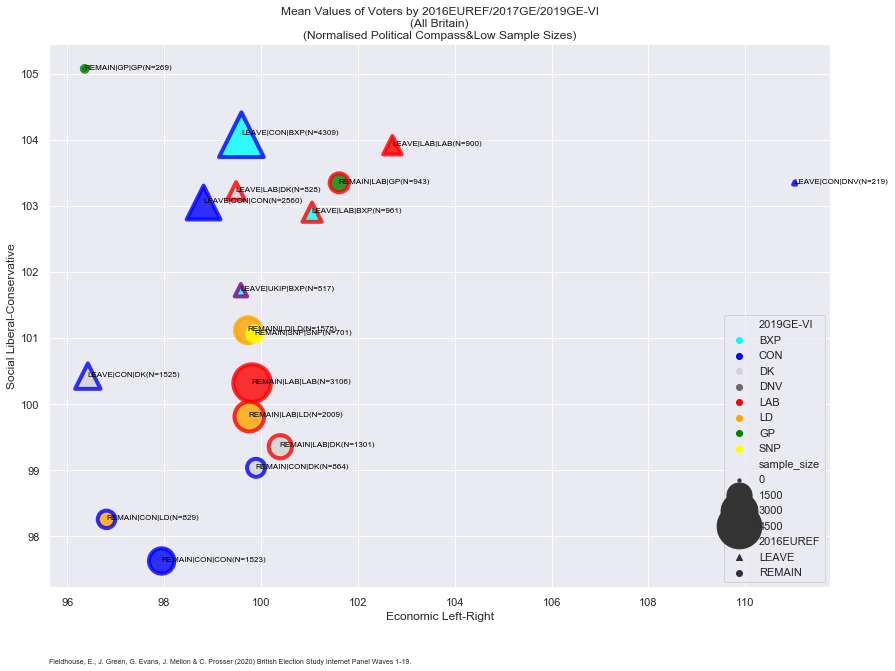

In [23]:
# %%time
# cat_variable = "profile_past_vote_2015"

title = "Mean Values of Voters by 2016EUREF/2017GE/2019GE-VI\n(All Britain)\n(Normalised Political Compass&Low Sample Sizes)"
fig = plt.figure(figsize=(14,10))

# restriction = BES_Panel["country"]=="England"
restriction = None
sample_size_boost=1
min_sample_size = 200

if restriction is None:
    BES = BES_Panel
else:
    BES = BES_Panel[restriction]
# BES = BES_Panel

var_list = ["profile_eurefvote","profile_past_vote_2017","generalElectionVoteW16"]
exposed_final_vote_name = "2019GE-VI"


mask = BES[var_list].notnull().all(axis=1)
cats = BES[var_list].apply(lambda x: x.map(replace_dict)).astype(str).apply(lambda x: "|".join(x),axis=1)
# mask = BES_Panel["profile_eurefvote"].notnull() & BES_Panel["profile_past_vote_2017"].notnull() & BES_Panel["euroElectionVoteW16"].notnull()
# cats = BES_Panel["profile_eurefvote"].map(replace_dict).astype(str)+"|"+BES_Panel["profile_past_vote_2017"].map(replace_dict).astype(str)+"|"+BES_Panel["euroElectionVoteW16"].map(replace_dict).astype(str)
cats[~mask] = np.nan
cats = cats.astype('category')

# cats = BES_Panel[cat_variable]
cat_sample_sizes = cats.value_counts()

cats.cat.remove_categories(cat_sample_sizes[cat_sample_sizes<min_sample_size].index,inplace=True)

cats = cats.apply(lambda x: x+"(N="+str(cat_sample_sizes.loc[x])+")")

# cats = cats.apply(lambda x: x if x in cat_sample_sizes[cat_sample_sizes>500].index else np.nan).astype('category')

# best_al_scale_variable = search(BES,"al_scale",mask=cats.notnull()).sort_values(ascending=False).index[0]
# best_lr_scale_variable = search(BES,"lr_scale",mask=cats.notnull()).sort_values(ascending=False).index[0]

best_weight_variable = search(BES,"wt_",mask=cats.notnull()).sort_values(ascending=False).index[0]
print(best_weight_variable)#,best_al_scale_variable,best_lr_scale_variable)
euro_election_al = pd.crosstab(index   = cats,
                       columns = pan_dataset_allr_values[pan_dataset_allr_values.columns[1]],
                       values  = BES[ best_weight_variable ],
                       aggfunc = sum,
                       normalize='index')
euro_election_al = euro_election_al.apply(lambda x: sum(x*euro_election_al.columns),axis=1)

euro_election_lr = pd.crosstab(index   = cats,
                       columns = pan_dataset_allr_values[pan_dataset_allr_values.columns[0]],
                       values  = BES[ best_weight_variable ],
                       aggfunc = sum,
                       normalize='index')
euro_election_lr = euro_election_lr.apply(lambda x: sum(x*euro_election_lr.columns),axis=1)

# euro_election_al = BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan).groupby(cats).mean()
# euro_election_lr = BES_Panel[best_lr_scale_variable].cat.codes.replace(-1,np.nan).groupby(cats).mean()

df = pd.concat([euro_election_lr,euro_election_al],axis=1).reset_index()
cat_name ="2016EUREF|2017GE|2019GE VI"
lr_scale_name = "Economic Left-Right"
al_scale_name = "Social Liberal-Conservative"
df.columns = [cat_name,lr_scale_name,al_scale_name]

df["2016EUREF"] = df[cat_name].apply(lambda x: x.split("|")[0])
df["2017GE"] = df[cat_name].apply(lambda x: x.split("|")[1])
df[exposed_final_vote_name] = df[cat_name].apply(lambda x: x.split("|")[2].split("(")[0])
df["sample_size"] = df[cat_name].apply(lambda x: int(x.split("|")[2].split("=")[1].split(")")[0]) ).astype('int')
euref_category = pd.api.types.CategoricalDtype( categories=["LEAVE", "REMAIN", "DNV"], ordered=True)
df["2016EUREF"] = df["2016EUREF"].astype(euref_category)


# df = df.drop(0)
from itertools import cycle
filled_markers = cycle(['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X'])

sct = sns.scatterplot(data=df,x=lr_scale_name,y=al_scale_name, 
                hue=exposed_final_vote_name ,palette = colourmap,style="2016EUREF", markers = ['^','o','s'],
                linewidth=4,edgecolor = df["2017GE"].map(colourmap),size = "sample_size",sizes=(10, 2000),
                alpha=.8)

#  s =df["sample_size"]*sample_size_boost,
#                 label=df[cat_name])
# s=1000,                
                
#                 style=cat_name,
#                 markers=filled_markers);
#                 size="size");

plt.title(title);

# +np.random.rand()*.2
for line in range(0,df.shape[0]):
     sct.text(df[lr_scale_name][line]-0.01, df[al_scale_name][line], 
     df[cat_name][line], horizontalalignment='left', 
     size=8, color='black')#, weight='semibold')

# lgnd = plt.legend(title='Smoker', loc='upper left')
# lgnd.legendHandles[0]._sizes = [30]
# lgnd.legendHandles[1]._sizes = [30]
# plt.show()
# plt.gca().legend()
plt.legend(loc='lower right')
sct.annotate(dataset_citation, (0,0), (0, -70),
                 xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ; 

fname = output_subfolder + title.replace(" ","_").replace("/","").replace("\n","") + ".png"
# fig.savefig( fname, bbox_inches='tight' ) 

In [26]:
BES_Panel["pastvote_ge_2019W19"].cat.categories

Index(['Conservative', 'Labour', 'Liberal Democrat',
       'Scottish National Party (SNP)', 'Plaid Cymru', 'Brexit Party', 'Green',
       'Other', 'Don't know'],
      dtype='object')

In [14]:
search(BES_Panel,"pastvote")

euRefpastVoteW11        27999
euRefpastVoteW12        31173
euRefpastVoteW13        28288
euRefpastVoteW14         3822
euRefpastVoteW15        27007
euRefpastVoteW17         2643
pastvote_EURefW17       34352
pastvote_eup_2019W18    27133
pastvote_ge_2019W19     28284
pastvote_eup_2019W19    23186
dtype: int64

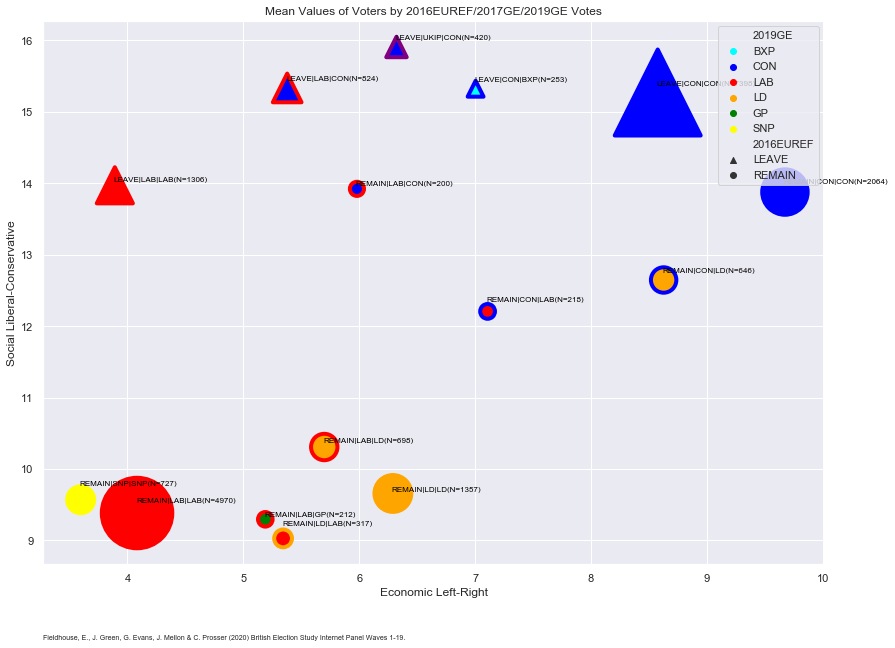

In [48]:
# %%time
# cat_variable = "profile_past_vote_2015"


# mask = BES_Panel["profile_eurefvote"].notnull() & BES_Panel["profile_past_vote_2017"].notnull() & BES_Panel["euroElectionVoteW16"].notnull()
# cats = BES_Panel["profile_eurefvote"].map(replace_dict).astype(str)+"|"+BES_Panel["profile_past_vote_2017"].map(replace_dict).astype(str)+"|"+BES_Panel["euroElectionVoteW16"].map(replace_dict).astype(str)
# cats[~mask] = np.nan
# cats = cats.astype('category')

# # cats = BES_Panel[cat_variable]
# cat_sample_sizes = cats.value_counts()

# cats.cat.remove_categories(cat_sample_sizes[cat_sample_sizes<200].index,inplace=True)

# cats = cats.apply(lambda x: x+"(N="+str(cat_sample_sizes.loc[x])+")")


title = "Mean Values of Voters by 2016EUREF/2017GE/2019GE-VI\n(England Only)\n(Normalised Political Compass)\n(Voronoi Overlap)"
# fig = plt.figure(figsize=(14,10))
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)

# restriction = BES_Panel["countryW19"]=="England"
restriction = None
sample_size_boost=1
min_sample_size = 200

if restriction is None:
    BES = BES_Panel
else:
    BES = BES_Panel[restriction]
# BES = BES_Panel

var_list = ["profile_eurefvote","profile_past_vote_2017","pastvote_ge_2019W19"]
exposed_final_vote_name = "2019GE-VI"


mask = BES[var_list].notnull().all(axis=1)
cats = BES[var_list].apply(lambda x: x.map(replace_dict)).astype(str).apply(lambda x: "|".join(x),axis=1)
# mask = BES_Panel["profile_eurefvote"].notnull() & BES_Panel["profile_past_vote_2017"].notnull() & BES_Panel["euroElectionVoteW16"].notnull()
# cats = BES_Panel["profile_eurefvote"].map(replace_dict).astype(str)+"|"+BES_Panel["profile_past_vote_2017"].map(replace_dict).astype(str)+"|"+BES_Panel["euroElectionVoteW16"].map(replace_dict).astype(str)
cats[~mask] = np.nan
cats = cats.astype('category')

# cats = BES_Panel[cat_variable]
cat_sample_sizes = cats.value_counts()

cats.cat.remove_categories(cat_sample_sizes[cat_sample_sizes<min_sample_size].index,inplace=True)

cats = cats.apply(lambda x: x+"(N="+str(cat_sample_sizes.loc[x])+")")


# cats = cats.apply(lambda x: x if x in cat_sample_sizes[cat_sample_sizes>500].index else np.nan).astype('category')

best_al_scale_variable = search(BES_Panel,"al_scale",mask=cats.notnull()).sort_values(ascending=False).index[0]
best_lr_scale_variable = search(BES_Panel,"lr_scale",mask=cats.notnull()).sort_values(ascending=False).index[0]

best_weight_variable = search(BES_Panel,"wt_",mask=BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan).notnull()).sort_values(ascending=False).index[0]
euro_election_al = pd.crosstab(index   = cats,
                       columns = BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan),
                       values  = BES_Panel[ best_weight_variable ],
                       aggfunc = sum,
                       normalize='index')
euro_election_al = euro_election_al.apply(lambda x: sum(x*euro_election_al.columns),axis=1)

euro_election_lr = pd.crosstab(index   = cats,
                       columns = BES_Panel[best_lr_scale_variable].cat.codes.replace(-1,np.nan),
                       values  = BES_Panel[ best_weight_variable ],
                       aggfunc = sum,
                       normalize='index')
euro_election_lr = euro_election_lr.apply(lambda x: sum(x*euro_election_lr.columns),axis=1)

# euro_election_al = BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan).groupby(cats).mean()
# euro_election_lr = BES_Panel[best_lr_scale_variable].cat.codes.replace(-1,np.nan).groupby(cats).mean()

df = pd.concat([euro_election_lr,euro_election_al],axis=1).reset_index()
cat_name ="2016EUREF|2017GE|2019GE"
lr_scale_name = "Economic Left-Right"
al_scale_name = "Social Liberal-Conservative"
df.columns = [cat_name,lr_scale_name,al_scale_name]

df["2016EUREF"] = df[cat_name].apply(lambda x: x.split("|")[0])
df["2017GE"] = df[cat_name].apply(lambda x: x.split("|")[1])
df["2019GE"] = df[cat_name].apply(lambda x: x.split("|")[2].split("(")[0])
df["sample_size"] = df[cat_name].apply(lambda x: int(x.split("|")[2].split("=")[1].split(")")[0]) )

# df = df.drop(0)
from itertools import cycle
filled_markers = cycle(['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X'])
# plt.figure(figsize=(14,10))
sct = sns.scatterplot(data=df,x=lr_scale_name,y=al_scale_name, 
                hue="2019GE" ,palette = colourmap,style="2016EUREF", markers = ['^','o'],
                linewidth=4,edgecolor = df["2017GE"].map(colourmap), s = df["sample_size"])
#                 label=df[cat_name])
# s=1000,                
                
#                 style=cat_name,
#                 markers=filled_markers);
#                 size="size");
plt.title("Mean Values of Voters by 2016EUREF/2017GE/2019GE Votes");

for line in range(0,df.shape[0]):
     sct.text(df[lr_scale_name][line]-0.01, df[al_scale_name][line]+np.random.rand()*.2, 
     df[cat_name][line], horizontalalignment='left', 
     size=8, color='black')#, weight='semibold')

# lgnd = plt.legend(title='Smoker', loc='upper left')
# lgnd.legendHandles[0]._sizes = [30]
# lgnd.legendHandles[1]._sizes = [30]
# plt.show()
# plt.gca().legend()
sct.annotate(dataset_citation, (0,0), (0, -70),
                 xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ; 

In [37]:
cats.cat.categories

Index(['LEAVE|CON|BXP(N=253)', 'LEAVE|CON|CON(N=7398)', 'LEAVE|LAB|CON(N=824)',
       'LEAVE|LAB|LAB(N=1306)', 'LEAVE|UKIP|CON(N=420)',
       'REMAIN|CON|CON(N=2064)', 'REMAIN|CON|LAB(N=218)',
       'REMAIN|CON|LD(N=646)', 'REMAIN|LAB|CON(N=200)',
       'REMAIN|LAB|LAB(N=4970)', 'REMAIN|LAB|LD(N=698)',
       'REMAIN|LAB|nan(N=212)', 'REMAIN|LD|LAB(N=317)', 'REMAIN|LD|LD(N=1357)',
       'REMAIN|SNP|SNP(N=727)'],
      dtype='object')

In [23]:
colourmap

{'LAB': 'red',
 'UKIP': 'purple',
 'CON': 'blue',
 'SNP': 'yellow',
 'BNP': 'black',
 'LD': 'orange',
 'DNV': 'dimgray',
 'DK': 'lightgray',
 'OTH': 'brown',
 'GP': 'green',
 'VER': 'pink',
 'PC': 'olive',
 'RES': 'peru',
 'BXP': 'cyan',
 'CUK': 'black',
 'LEAVE': 'blue',
 'REMAIN': 'yellow'}

In [30]:
BES[var_list].apply(lambda x: x.map(replace_dict))

,profile_eurefvote,profile_past_vote_2017,pastvote_ge_2019W19
0,LEAVE,LAB,BXP
1,REMAIN,LAB,CON
2,LEAVE,NaN,CON
3,REMAIN,PC,NaN
4,LEAVE,CON,CON
...,...,...,...
97153,NaN,NaN,NaN
97154,LEAVE,NaN,NaN
97155,REMAIN,LAB,NaN
97156,NaN,NaN,NaN


In [31]:
replace_dict

{'Labour Party': 'LAB',
 'United Kingdom Independence Party (UKIP)': 'UKIP',
 'Labour': 'LAB',
 'Conservative Party': 'CON',
 'Conservative': 'CON',
 'Liberal Democrats': 'LD',
 'Did not vote': 'DNV',
 'Scottish National Party': 'SNP',
 'Scottish National Party (SNP)': 'SNP',
 'British National Party (BNP)': 'BNP',
 'Green Party': 'GP',
 'Liberal Democrat': 'LD',
 "Don't know": 'DK',
 'Some other party': 'OTH',
 'Veritas': 'VER',
 'Plaid Cymru': 'PC',
 'Other': 'OTH',
 'Respect': 'RES',
 'I would not vote': 'DNV',
 'Brexit Party': 'BXP',
 'Change UK- The Independent Group': 'CUK',
 'Leave the EU': 'LEAVE',
 'Stay/remain in the EU': 'REMAIN'}

In [42]:
BES[["pastvote_ge_2019W19"]].apply(lambda x: x.map(replace_dict))["pastvote_ge_2019W19"].value_counts()

CON    12666
LAB     8244
LD      3579
SNP     1249
BXP      722
OTH      553
DK       231
PC       182
Name: pastvote_ge_2019W19, dtype: int64

In [60]:
mask = BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan).notnull() & BES_Panel[best_weight_variable].notnull()
weighted_qcut(BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan)[mask],BES_Panel[best_weight_variable][mask],100)

0        (0.52, 0.53]
2        (0.92, 0.93]
3        (0.17, 0.18]
4        (0.96, 0.97]
6         (0.8, 0.81]
             ...     
97127    (0.08, 0.09]
97132    (0.28, 0.29]
97136    (0.61, 0.62]
97151    (0.13, 0.14]
97157    (0.13, 0.14]
Name: wt_new_W17, Length: 29773, dtype: category
Categories (100, interval[float64]): [(0.0, 0.01] < (0.01, 0.02] < (0.02, 0.03] < (0.03, 0.04] ... (0.96, 0.97] < (0.97, 0.98] < (0.98, 0.99] < (0.99, 1.0]]

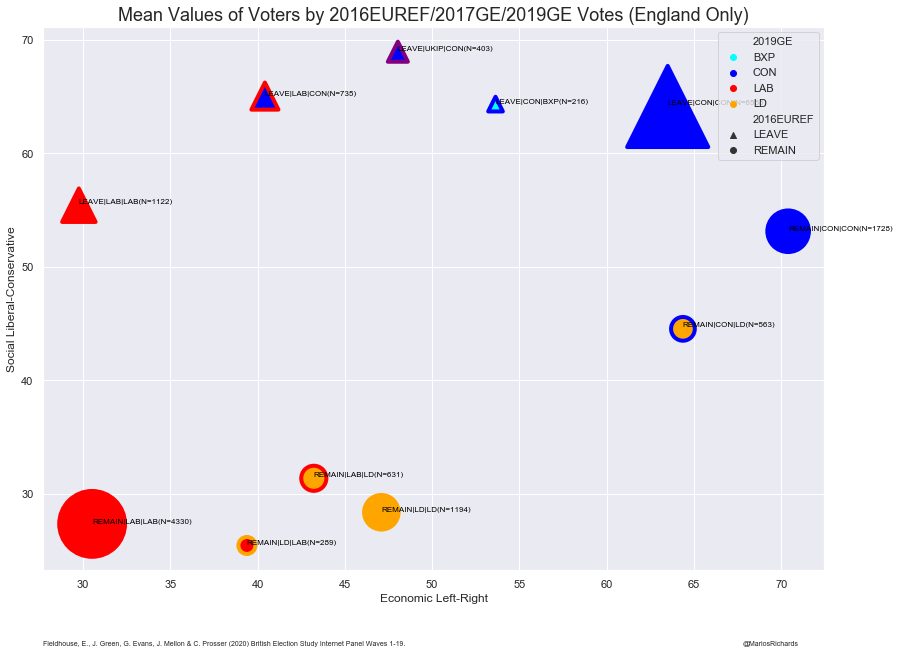

In [7]:
# %%time
# cat_variable = "profile_past_vote_2015"


# mask = BES_Panel["profile_eurefvote"].notnull() & BES_Panel["profile_past_vote_2017"].notnull() & BES_Panel["euroElectionVoteW16"].notnull()
# cats = BES_Panel["profile_eurefvote"].map(replace_dict).astype(str)+"|"+BES_Panel["profile_past_vote_2017"].map(replace_dict).astype(str)+"|"+BES_Panel["euroElectionVoteW16"].map(replace_dict).astype(str)
# cats[~mask] = np.nan
# cats = cats.astype('category')

# # cats = BES_Panel[cat_variable]
# cat_sample_sizes = cats.value_counts()

# cats.cat.remove_categories(cat_sample_sizes[cat_sample_sizes<200].index,inplace=True)

# cats = cats.apply(lambda x: x+"(N="+str(cat_sample_sizes.loc[x])+")")


title = "Mean Values of Voters by 2016EUREF/2017GE/2019GE-VI\n(England Only)\n(Normalised Political Compass)\n(Voronoi Overlap)"
# fig = plt.figure(figsize=(14,10))
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)

restriction = BES_Panel["countryW19"]=="English"
# restriction = None
sample_size_boost=1
min_sample_size = 200
BES = BES_Panel
if restriction is None:
#     BES = BES_Panel
    specific_mask = 1
else:
#     BES = BES_Panel[restriction]
    specific_mask = restriction
# BES = BES_Panel

var_list = ["profile_eurefvote","profile_past_vote_2017","pastvote_ge_2019W19"]
exposed_final_vote_name = "2019GE-VI"


mask = BES[var_list].notnull().all(axis=1) & specific_mask
cats = BES[var_list].apply(lambda x: x.map(replace_dict)).astype(str).apply(lambda x: "|".join(x),axis=1)
# mask = BES_Panel["profile_eurefvote"].notnull() & BES_Panel["profile_past_vote_2017"].notnull() & BES_Panel["euroElectionVoteW16"].notnull()
# cats = BES_Panel["profile_eurefvote"].map(replace_dict).astype(str)+"|"+BES_Panel["profile_past_vote_2017"].map(replace_dict).astype(str)+"|"+BES_Panel["euroElectionVoteW16"].map(replace_dict).astype(str)
cats[~mask] = np.nan
cats = cats.astype('category')

# cats = BES_Panel[cat_variable]
cat_sample_sizes = cats.value_counts()

cats.cat.remove_categories(cat_sample_sizes[cat_sample_sizes<min_sample_size].index,inplace=True)

cats = cats.apply(lambda x: x+"(N="+str(cat_sample_sizes.loc[x])+")")


# cats = cats.apply(lambda x: x if x in cat_sample_sizes[cat_sample_sizes>500].index else np.nan).astype('category')

best_al_scale_variable = search(BES_Panel,"al_scale",mask=cats.notnull()).sort_values(ascending=False).index[0]
best_lr_scale_variable = search(BES_Panel,"lr_scale",mask=cats.notnull()).sort_values(ascending=False).index[0]

best_weight_variable = search(BES_Panel,"wt_",mask=BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan).notnull()).sort_values(ascending=False).index[0]
al_mask = BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan).notnull() & BES_Panel[best_weight_variable].notnull() & mask
euro_election_al = pd.crosstab(index   = cats,
                       columns = weighted_qcut(BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan)[al_mask],BES_Panel[best_weight_variable][al_mask],100).cat.codes,
                       values  = BES_Panel[ best_weight_variable ][al_mask],
                       aggfunc = sum,
                       normalize='index')
euro_election_al = euro_election_al.apply(lambda x: sum(x*euro_election_al.columns),axis=1)
lr_mask = BES_Panel[best_lr_scale_variable].cat.codes.replace(-1,np.nan).notnull() & BES_Panel[best_weight_variable].notnull()&mask
euro_election_lr = pd.crosstab(index   = cats,
                       columns = weighted_qcut(BES_Panel[best_lr_scale_variable].cat.codes.replace(-1,np.nan)[lr_mask],
                                               BES_Panel[best_weight_variable][lr_mask],100).cat.codes,
                       values  = BES_Panel[ best_weight_variable ][lr_mask],
                       aggfunc = sum,
                       normalize='index')
euro_election_lr = euro_election_lr.apply(lambda x: sum(x*euro_election_lr.columns),axis=1)

# euro_election_al = BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan).groupby(cats).mean()
# euro_election_lr = BES_Panel[best_lr_scale_variable].cat.codes.replace(-1,np.nan).groupby(cats).mean()

df = pd.concat([euro_election_lr,euro_election_al],axis=1).reset_index()
cat_name ="2016EUREF|2017GE|2019GE"
lr_scale_name = "Economic Left-Right"
al_scale_name = "Social Liberal-Conservative"
df.columns = [cat_name,lr_scale_name,al_scale_name]

df["2016EUREF"] = df[cat_name].apply(lambda x: x.split("|")[0])
df["2017GE"] = df[cat_name].apply(lambda x: x.split("|")[1])
df["2019GE"] = df[cat_name].apply(lambda x: x.split("|")[2].split("(")[0])
df["sample_size"] = df[cat_name].apply(lambda x: int(x.split("|")[2].split("=")[1].split(")")[0]) )

# df = df.drop(0)
from itertools import cycle
filled_markers = cycle(['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X'])
# plt.figure(figsize=(14,10))
sct = sns.scatterplot(data=df,x=lr_scale_name,y=al_scale_name, 
                hue="2019GE" ,palette = colourmap,style="2016EUREF", markers = ['^','o'],
                linewidth=4,edgecolor = df["2017GE"].map(colourmap), s = df["sample_size"])
#                 label=df[cat_name])
# s=1000,                
                
#                 style=cat_name,
#                 markers=filled_markers);
#                 size="size");
plt.title("Mean Values of Voters by 2016EUREF/2017GE/2019GE Votes (England Only)", fontsize=18);

for line in range(0,df.shape[0]):
     sct.text(df[lr_scale_name][line]-0.01, df[al_scale_name][line]+np.random.rand()*.2, 
     df[cat_name][line], horizontalalignment='left', 
     size=8, color='black')#, weight='semibold')

# lgnd = plt.legend(title='Smoker', loc='upper left')
# lgnd.legendHandles[0]._sizes = [30]
# lgnd.legendHandles[1]._sizes = [30]
# plt.show()
# plt.gca().legend()
sct.annotate(dataset_citation, (0,0), (0, -70),
                 xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ; 
sct.annotate("@MariosRichards", (0,0), (700, -70),
                 xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ; 

In [92]:
cats.name = "temp"

In [12]:
weighted_value_counts(cats,
                      BES_Panel[search(BES_Panel,"wt_",mask=cats.notnull()).sort_values(ascending=False).index[0]],
                      normalize=True,perc=True,decimal_places=2).sum()

weighted_sample_percentage       46.81
raw_sample_size               17799.00
dtype: float64

In [94]:
    normalize = kwargs.get('normalize', False)
    perc = kwargs.get('perc', False)
    decimal_places = kwargs.get('decimal_places', 2)
    suppress_raw_samplesize = kwargs.get('suppress_raw_samplesize', False)

In [88]:
BES_Panel[search(BES_Panel,"wt_",mask=cats.notnull()).sort_values(ascending=False).index[0]]

0        0.913611
1        0.349251
2        0.542422
3        0.788158
4        0.954995
           ...   
97153         NaN
97154         NaN
97155         NaN
97156         NaN
97157         NaN
Name: wt_new_W19_result, Length: 97158, dtype: float32

In [13]:
search(BES_Panel,"past")

headHouseholdPastW1       30568
headHouseholdPastW2        2402
headHouseholdPastW3        2601
headHouseholdPastW4        4521
partyMemberPastW6          3376
headHouseholdPastW7        7653
partyMemberPastW8          2519
headHouseholdPastW9       26133
partyMemberPastW10         2462
headHouseholdPastW10      26821
partyMemberPastW11         2952
headHouseholdPastW11      27163
euRefpastVoteW11          27999
partyMemberPastW12         3237
euRefpastVoteW12          31173
partyMemberPastW13          114
headHouseholdPastW13      27415
euRefpastVoteW13          28288
partyMemberPastW14         2817
euRefpastVoteW14           3822
partyMemberPastW15         2916
euRefpastVoteW15          27007
euRefpastVoteW17           2643
pastvote_EURefW17         34352
pastvote_eup_2019W18      27133
pastvote_ge_2019W19       28284
pastvote_eup_2019W19      23186
headHouseholdPast         63607
profile_past_vote_2005    56631
profile_past_vote_2010    65581
profile_past_vote_2017    60451
profile_

In [34]:
mask = BES_Panel[["profile_past_vote_2017","pastvote_ge_2019W19","euRefVoteW19"]].notnull().all(axis=1)
search(BES_Panel,"euref",mask=mask).sort_values().tail(10)
mask.sum()

28284

In [33]:
BES_Panel["pastvote_ge_2019W19"].value_counts().sum()

28284

In [32]:
BES_Panel["generalElectionVoteW18"].value_counts().sum()

37372

In [35]:
BES_Panel["profile_past_vote_2017"].value_counts()

Labour                                      23817
Conservative                                23760
Liberal Democrat                             5275
Scottish National Party (SNP)                2531
United Kingdom Independence Party (UKIP)     1484
Green Party                                  1285
Don't know                                   1179
Other                                         723
Plaid Cymru                                   396
British National Party (BNP)                    1
Name: profile_past_vote_2017, dtype: int64

In [37]:
BES_Panel[BES_Panel["pastvote_ge_2019W19"].notnull()&BES_Panel["profile_past_vote_2017"].isnull()]

,id,wave1,wave2,wave3,wave4,wave5,wave6,wave7,wave8,wave9,...,profile_turnout_2017,profile_past_vote_2015,profile_turnout_2015,profile_eurefvote,profile_eurefturnout,profile_scotref_turnout,profile_scotref_vote,cogempathyIRTW14,affempathyIRTW14,zeroSumIRTW14
2,66250,False,False,False,False,False,False,False,False,False,...,"No, did not vote",NaN,"No, did not vote",Leave the EU,"Yes, voted",NaN,NaN,-0.346240,-0.132743,NaN
73,13163,True,True,True,False,True,True,False,True,False,...,"No, did not vote",Green Party,"Yes, voted",NaN,"No, did not vote",NaN,NaN,NaN,NaN,NaN
84,18401,True,False,False,False,False,False,True,True,True,...,"No, did not vote",NaN,"No, did not vote",NaN,"No, did not vote",NaN,NaN,-0.663092,-1.140944,NaN
119,91721,False,False,False,False,False,False,False,False,False,...,"No, did not vote",NaN,"No, did not vote",Stay/remain in the EU,"Yes, voted","Yes, I voted",I voted 'Yes' (Scotland should be an independe...,NaN,NaN,NaN
144,91098,False,False,False,False,False,False,False,False,False,...,"No, did not vote",Scottish National Party (SNP),"Yes, voted",NaN,"No, did not vote","Yes, I voted",I voted 'Yes' (Scotland should be an independe...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32091,61122,False,False,False,False,False,False,False,False,False,...,"No, did not vote",NaN,"No, did not vote",NaN,"No, did not vote","No, I did not vote",NaN,NaN,NaN,NaN
32121,93240,False,False,False,False,False,False,False,False,False,...,"No, did not vote",NaN,"No, did not vote",NaN,"No, did not vote",NaN,NaN,NaN,NaN,NaN
32157,90837,False,False,False,False,False,False,False,False,False,...,"No, did not vote",NaN,"No, did not vote",NaN,"No, did not vote",NaN,NaN,NaN,NaN,NaN
32161,58459,False,False,False,False,False,False,False,False,False,...,"No, did not vote",Conservative,"Yes, voted",Leave the EU,"Yes, voted",NaN,NaN,1.398872,1.653829,NaN


In [84]:
BES_Panel[search(BES_Panel,"wt_",mask=cats.notnull()).sort_values(ascending=False).index[0]]

0        0.913611
1        0.349251
2        0.542422
3        0.788158
4        0.954995
           ...   
97153         NaN
97154         NaN
97155         NaN
97156         NaN
97157         NaN
Name: wt_new_W19_result, Length: 97158, dtype: float32

In [62]:
search(BES_Panel,"pastvote|voted")

askVoteDiscuss1W2       25260
askVoteDiscuss2W2       18785
askVoteDiscuss3W2       13837
euRefpastVoteW11        27999
askVoteDiscuss1W12       4916
askVoteDiscuss2W12       3848
askVoteDiscuss3W12       2993
euRefpastVoteW12        31173
euRefpastVoteW13        28288
euRefpastVoteW14         3822
euRefpastVoteW15        27007
euRefpastVoteW17         2643
pastvote_EURefW17       34352
pastvote_eup_2019W18    27133
voted2017W19            32177
pastvote_ge_2019W19     28284
pastvote_eup_2019W19    23186
voted2015               30237
dtype: int64

In [64]:
search(BES_Panel,"turnout.*W19")

genElecTurnoutRetroW19    32177
dtype: int64

In [65]:
search(BES_Panel,"TurnoutRetro")

euroTurnoutRetroW2            30262
localTurnoutRetroW2           12095
genElecTurnoutRetroW6         30258
localTurnoutRetroW6           30258
localTurnoutRetroW8           22878
welshTurnoutRetroW8            2571
scotTurnoutRetroW8             4278
euRefTurnoutRetroW9           30036
euRefTurnoutRetroW11          30956
localTurnoutRetroW12          30717
euRefTurnoutRetroW12          34394
genElecTurnoutRetroW13        31136
euRefTurnoutRetroW13          31136
localTurnoutRetroW14          25627
euRefTurnoutRetroW14           5184
euRefTurnoutRetroW15          30842
euroTurnoutRetroW16           37959
localTurnoutRetroW16          23536
euRefTurnoutRetroW17           3564
genElecTurnoutRetro2017W18     9369
genElecTurnoutRetroW19        32177
dtype: int64

In [94]:
BES_Panel["genElecTurnoutRetroW19"].value_counts()

Yes, voted          28901
No, did not vote     3116
Don't know            160
Name: genElecTurnoutRetroW19, dtype: int64

In [58]:
BES_Panel["voted2015"].apply(lambda x: x in [2.0,99.0])

4210

In [54]:
BES_Panel[["voted2015","profile_turnout_2015"]]

,voted2015,profile_turnout_2015
0,1.0,"Yes, voted"
1,1.0,"Yes, voted"
2,NaN,"No, did not vote"
3,1.0,"Yes, voted"
4,NaN,"Yes, voted"
...,...,...
97153,NaN,"Yes, voted"
97154,NaN,"Yes, voted"
97155,NaN,"Yes, voted"
97156,NaN,NaN


In [119]:
search(BES_Panel,"eurefturnout")

euRefTurnoutW7          30895
euRefTurnoutW8          29175
euRefTurnoutRetroW9     30036
euRefTurnoutRetroW11    30956
euRefTurnoutRetroW12    34394
euRefTurnoutRetroW13    31136
euRefTurnoutRetroW14     5184
euRefTurnoutRetroW15    30842
euRefTurnoutRetroW17     3564
profile_eurefturnout    79511
dtype: int64

In [118]:
BES_Panel["profile_eurefturnout"]

0        Yes, voted
1        Yes, voted
2        Yes, voted
3        Yes, voted
4        Yes, voted
            ...    
97153           NaN
97154    Yes, voted
97155    Yes, voted
97156           NaN
97157    Yes, voted
Name: profile_eurefturnout, Length: 97158, dtype: category
Categories (3, object): [No, did not vote < Yes, voted < Don't know]

In [122]:
mask = BES_Panel[["profile_past_vote_2017","pastvote_ge_2019W19"]].notnull().all(axis=1)
search(BES_Panel,"euref",mask=mask).sort_values()

euRefVoteHypotheticalW9      662
euRefpastVoteW17            1304
euRefVoteSqueezeW8          1470
euRefpastVoteW14            1511
euRefTurnoutRetroW17        1706
                           ...  
euRefDoOverW18             25650
profile_eurefvote          31180
profile_eurefturnout       31180
euRefDoOverW19             31443
euRefVoteW19               31443
Length: 67, dtype: int64

In [151]:
BES[var_list]

,profile_eurefvote,profile_past_vote_2017,pastvote_ge_2019W19
0,Leave the EU,Labour,Brexit Party
1,Stay/remain in the EU,Labour,Conservative
2,Leave the EU,Did not vote,Conservative
3,Stay/remain in the EU,Plaid Cymru,Did not vote
4,Leave the EU,Conservative,Conservative
...,...,...,...
97153,NaN,NaN,NaN
97154,Leave the EU,NaN,NaN
97155,Stay/remain in the EU,Labour,NaN
97156,NaN,NaN,NaN


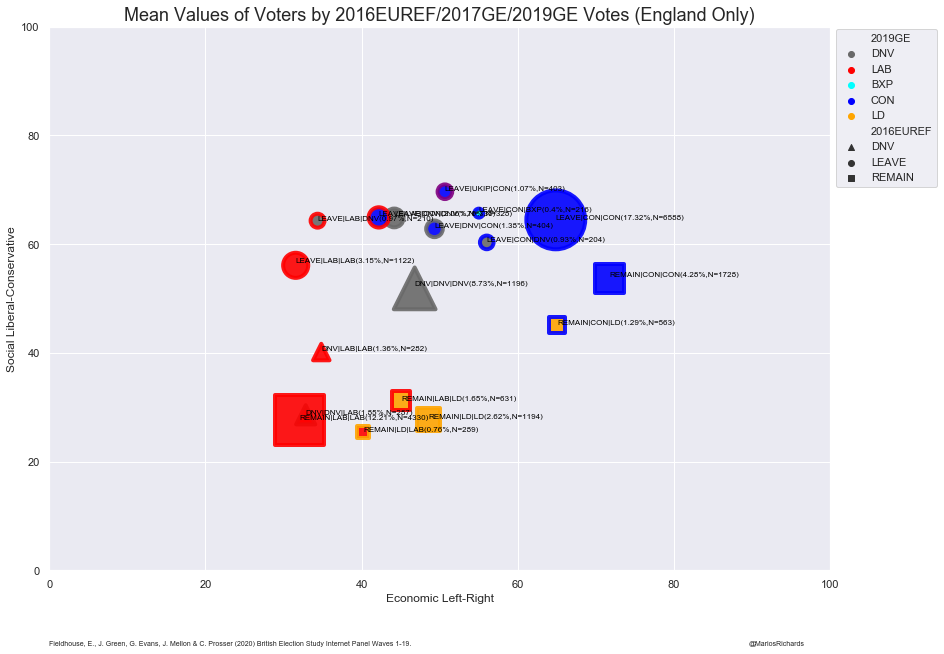

In [247]:
# %%time
# cat_variable = "profile_past_vote_2015"


# mask = BES_Panel["profile_eurefvote"].notnull() & BES_Panel["profile_past_vote_2017"].notnull() & BES_Panel["euroElectionVoteW16"].notnull()
# cats = BES_Panel["profile_eurefvote"].map(replace_dict).astype(str)+"|"+BES_Panel["profile_past_vote_2017"].map(replace_dict).astype(str)+"|"+BES_Panel["euroElectionVoteW16"].map(replace_dict).astype(str)
# cats[~mask] = np.nan
# cats = cats.astype('category')

# # cats = BES_Panel[cat_variable]
# cat_sample_sizes = cats.value_counts()

# cats.cat.remove_categories(cat_sample_sizes[cat_sample_sizes<200].index,inplace=True)

# cats = cats.apply(lambda x: x+"(N="+str(cat_sample_sizes.loc[x])+")")


title = "Mean Values of Voters by 2016EUREF/2017GE/2019GE-VI\n(England Only)\n(Normalised Political Compass)\n(Voronoi Overlap)"
# fig = plt.figure(figsize=(14,10))
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)

restriction = BES_Panel["countryW19"]=="English"
# restriction = None
sample_size_boost=200
min_sample_size = 200

BES = BES_Panel
if restriction is None:
#     BES = BES_Panel
    specific_mask = 1
else:
#     BES = BES_Panel[restriction]
    specific_mask = restriction
# BES = BES_Panel

var_list = ["profile_eurefvote","profile_past_vote_2017","pastvote_ge_2019W19"]
exposed_final_vote_name = "2019GE-VI"


best_weight_variable = 'wt_new_W19_result'
wts = BES_Panel[best_weight_variable].copy()
wts[~specific_mask] = np.nan


mask = BES[var_list].notnull().all(axis=1) & specific_mask
cats = BES[var_list].apply(lambda x: x.map(replace_dict)).astype(str).apply(lambda x: "|".join(x),axis=1)
# mask = BES_Panel["profile_eurefvote"].notnull() & BES_Panel["profile_past_vote_2017"].notnull() & BES_Panel["euroElectionVoteW16"].notnull()
# cats = BES_Panel["profile_eurefvote"].map(replace_dict).astype(str)+"|"+BES_Panel["profile_past_vote_2017"].map(replace_dict).astype(str)+"|"+BES_Panel["euroElectionVoteW16"].map(replace_dict).astype(str)
cats[~mask] = np.nan
cats = cats.astype('category')

# cats = BES_Panel[cat_variable]
cat_sample_sizes = cats.value_counts()
weighted_perc = round(weighted_value_counts(cats,BES_Panel["wt_new_W19_result"],normalize=True, perc=True)["weighted_sample_percentage"],2).apply(lambda x: str(x) +"%"  )

cats.cat.remove_categories(cat_sample_sizes[cat_sample_sizes<min_sample_size].index,inplace=True)

cats = cats.apply(lambda x: x+"("+weighted_perc.loc[x]+",N="+str(cat_sample_sizes.loc[x])+")")


# cats = cats.apply(lambda x: x if x in cat_sample_sizes[cat_sample_sizes>500].index else np.nan).astype('category')

best_al_scale_variable = search(BES_Panel,"al_scale",mask=cats.notnull()).sort_values(ascending=False).index[0]
best_lr_scale_variable = search(BES_Panel,"lr_scale",mask=cats.notnull()).sort_values(ascending=False).index[0]

# best_weight_variable = search(BES_Panel,"wt_",mask=BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan).notnull()).sort_values(ascending=False).index[0]


al_mask = BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan).notnull() & wts.notnull() & mask
euro_election_al = pd.crosstab(index   = cats,
                       columns = weighted_qcut(BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan)[al_mask],
                                               wts[al_mask],100).cat.codes,
                       values  = wts[al_mask],
                       aggfunc = sum,
                       normalize='index')
euro_election_al = euro_election_al.apply(lambda x: sum(x*euro_election_al.columns),axis=1)
lr_mask = BES_Panel[best_lr_scale_variable].cat.codes.replace(-1,np.nan).notnull() & wts.notnull()&mask
euro_election_lr = pd.crosstab(index   = cats,
                       columns = weighted_qcut(BES_Panel[best_lr_scale_variable].cat.codes.replace(-1,np.nan)[lr_mask],
                                               wts[lr_mask],100).cat.codes,
                       values  = wts[lr_mask],
                       aggfunc = sum,
                       normalize='index')
euro_election_lr = euro_election_lr.apply(lambda x: sum(x*euro_election_lr.columns),axis=1)

# euro_election_al = BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan).groupby(cats).mean()
# euro_election_lr = BES_Panel[best_lr_scale_variable].cat.codes.replace(-1,np.nan).groupby(cats).mean()

df = pd.concat([euro_election_lr,euro_election_al],axis=1).reset_index()
cat_name ="2016EUREF|2017GE|2019GE"
lr_scale_name = "Economic Left-Right"
al_scale_name = "Social Liberal-Conservative"
df.columns = [cat_name,lr_scale_name,al_scale_name]

df["2016EUREF"] = df[cat_name].apply(lambda x: x.split("|")[0])
df["2017GE"] = df[cat_name].apply(lambda x: x.split("|")[1])
df["2019GE"] = df[cat_name].apply(lambda x: x.split("|")[2].split("(")[0])
df["sample_size"] = df[cat_name].apply(lambda x: int(x.split("|")[2].split("=")[1].split(")")[0]) )
df["wt_sample_perc"] = df[cat_name].apply(lambda x: float(x.split("|")[2].split("(")[1].split("%")[0]) ).astype('float')

# df = df.drop(0)
from itertools import cycle
filled_markers = cycle(['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X'])
# plt.figure(figsize=(14,10))
sct = sns.scatterplot(data=df,x=lr_scale_name,y=al_scale_name, 
                hue="2019GE" ,palette = colourmap,style="2016EUREF", markers = ['^','o','s','D'],
                linewidth=4,edgecolor = df["2017GE"].map(colourmap), s = df["wt_sample_perc"]*sample_size_boost,
                alpha=.9)
#                 label=df[cat_name])
# s=1000,                
                
#                 style=cat_name,
#                 markers=filled_markers);
#                 size="size");
plt.title("Mean Values of Voters by 2016EUREF/2017GE/2019GE Votes (England Only)", fontsize=18);

for line in range(0,df.shape[0]):
     sct.text(df[lr_scale_name][line]-0.01, df[al_scale_name][line]+np.random.rand()*.5, 
     df[cat_name][line], horizontalalignment='left', 
     size=8, color='black')#, weight='semibold')

plt.legend(loc='center left', bbox_to_anchor=(1, .85))        
# lgnd = plt.legend(title='Smoker', loc='upper left')
# lgnd.legendHandles[0]._sizes = [30]
# lgnd.legendHandles[1]._sizes = [30]
# plt.show()
# plt.gca().legend()
plt.xlim([0,100]);
plt.ylim([0,100]);
sct.annotate(dataset_citation, (0,0), (0, -70),
                 xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ; 
sct.annotate("@MariosRichards", (0,0), (700, -70),
                 xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ; 

In [69]:
df.head(60)

,2016EUREF|2017GE|2019GE,Economic Left-Right,Social Liberal-Conservative,2016EUREF,2017GE,2019GE,sample_size,wt_sample_perc
0,"<18|<18|CON(0.68%,N=50)",72.288297,50.722889,<18,<18,CON,50,0.68
1,"<18|<18|DNV(1.14%,N=63)",55.456858,38.063255,<18,<18,DNV,63,1.14
2,"<18|<18|LAB(1.49%,N=148)",28.396231,19.379763,<18,<18,LAB,148,1.49
3,"<18|LAB|LAB(0.33%,N=52)",26.288996,17.217724,<18,LAB,LAB,52,0.33
4,"DNV|CON|CON(0.69%,N=188)",63.947730,54.520150,DNV,CON,CON,188,0.69
5,"DNV|CON|DNV(0.34%,N=52)",63.191234,59.284412,DNV,CON,DNV,52,0.34
6,"DNV|DNV|CON(0.78%,N=182)",56.628887,60.046951,DNV,DNV,CON,182,0.78
7,"DNV|DNV|DNV(8.96%,N=1304)",46.403209,52.841275,DNV,DNV,DNV,1304,8.96
8,"DNV|DNV|LAB(0.96%,N=193)",40.324391,44.809415,DNV,DNV,LAB,193,0.96
9,"DNV|DNV|LD(0.33%,N=86)",53.004990,42.090013,DNV,DNV,LD,86,0.33


In [67]:
pan_dataset_votes["2017GEVote_complete"].value_counts()

Unknown                                     26009
Conservative                                23716
Labour                                      23624
Did not vote                                 8975
Liberal Democrat                             5245
Scottish National Party (SNP)                2515
United Kingdom Independence Party (UKIP)     1482
Too Young To Vote                            1403
Green Party                                  1274
Don't know                                   1173
Other                                         716
Not Present                                   629
Plaid Cymru                                   396
British National Party (BNP)                    1
Name: 2017GEVote_complete, dtype: int64

In [58]:
pan_dataset_votes.columns

Index(['2005GEVote', '2005GEVote_complete', '2010GEVote',
       '2010GEVote_complete', '2015GEVote', '2015GEVote_complete',
       '2017GEVote', '2017GEVote_complete', '2019GEVote',
       '2019GEVote_complete', '2016EUVote', '2016EUVote_complete'],
      dtype='object')

In [84]:
var_list_short = [x.replace("Vote","").replace("_complete","") for x in var_list]
"|".join( var_list_short )

'2005GE|2010GE|2019GE'

In [158]:
def politicluster_plot(title, var_list, best_weight_variable,restriction,sample_size_boost,min_sample_size):

    var_list_short = [x.replace("Vote","").replace("_complete","") for x in var_list]
    
    fig = plt.figure(figsize=(14,10))
    ax = fig.add_subplot(111)
    exposed_final_vote_name = var_list_short[-1]

    wts = BES_Panel[best_weight_variable].copy()    

    BES = BES_Panel
    if restriction is None:
        specific_mask = True
        mask = BES[var_list].notnull().all(axis=1) & wts.notnull()
    else:
#         specific_mask = restriction
        wts[~restriction] = np.nan
        mask = BES[var_list].notnull().all(axis=1) & restriction & wts.notnull()


    
    cats = BES[var_list].apply(lambda x: x.map(replace_dict)).astype(str).apply(lambda x: "|".join(x),axis=1)

    cats[~mask] = np.nan
    cats = cats.astype('category')

    cat_sample_sizes = cats.value_counts()
    weighted_perc = round(weighted_value_counts(cats,BES_Panel[best_weight_variable],normalize=True, perc=True)["weighted_sample_percentage"],2).apply(lambda x: str(x) +"%"  )

    cats.cat.remove_categories(cat_sample_sizes[cat_sample_sizes<min_sample_size].index,inplace=True)

    cats = cats.apply(lambda x: x+"("+weighted_perc.loc[x]+",N="+str(cat_sample_sizes.loc[x])+")")


    best_al_scale_variable = search(BES_Panel,"al_scale",mask=cats.notnull()).sort_values(ascending=False).index[0]
    best_lr_scale_variable = search(BES_Panel,"lr_scale",mask=cats.notnull()).sort_values(ascending=False).index[0]

    # best_weight_variable = search(BES_Panel,"wt_",mask=BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan).notnull()).sort_values(ascending=False).index[0]


    al_mask = BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan).notnull() & wts.notnull() & mask
    euro_election_al = pd.crosstab(index   = cats,
                           columns = weighted_qcut(BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan)[al_mask],
                                                   wts[al_mask],100).cat.codes,
                           values  = wts[al_mask],
                           aggfunc = sum,
                           normalize='index')
    euro_election_al = euro_election_al.apply(lambda x: sum(x*euro_election_al.columns),axis=1)
    lr_mask = BES_Panel[best_lr_scale_variable].cat.codes.replace(-1,np.nan).notnull() & wts.notnull()&mask
    euro_election_lr = pd.crosstab(index   = cats,
                           columns = weighted_qcut(BES_Panel[best_lr_scale_variable].cat.codes.replace(-1,np.nan)[lr_mask],
                                                   wts[lr_mask],100).cat.codes,
                           values  = wts[lr_mask],
                           aggfunc = sum,
                           normalize='index')
    euro_election_lr = euro_election_lr.apply(lambda x: sum(x*euro_election_lr.columns),axis=1)

    # euro_election_al = BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan).groupby(cats).mean()
    # euro_election_lr = BES_Panel[best_lr_scale_variable].cat.codes.replace(-1,np.nan).groupby(cats).mean()

    df = pd.concat([euro_election_lr,euro_election_al],axis=1).reset_index()
    cat_name = "|".join( var_list_short )
    lr_scale_name = "Economic Left-Right"
    al_scale_name = "Social Liberal-Conservative"
    df.columns = [cat_name,lr_scale_name,al_scale_name]

    df[ var_list_short[0] ] = df[cat_name].apply(lambda x: x.split("|")[0])
    df[ var_list_short[1] ] = df[cat_name].apply(lambda x: x.split("|")[1])
    df[ var_list_short[2] ] = df[cat_name].apply(lambda x: x.split("|")[2].split("(")[0])
    df["sample_size"] = df[cat_name].apply(lambda x: int(x.split("|")[2].split("=")[1].split(")")[0]) )
    df["wt_sample_perc"] = df[cat_name].apply(lambda x: float(x.split("|")[2].split("(")[1].split("%")[0]) ).astype('float')

    # df = df.drop(0)
    from itertools import cycle
    filled_markers = cycle(['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X','H','*','d'])
    # plt.figure(figsize=(14,10))
    sct = sns.scatterplot(data=df,x=lr_scale_name,y=al_scale_name, 
                    hue=var_list_short[2], palette = colourmap, style=var_list_short[0],
                    markers = ['^','o','s','D','p','h','v','<','>','8'],
                    linewidth=3,edgecolor = df[ var_list_short[1] ].map(colourmap),
                    s = df["wt_sample_perc"]*sample_size_boost,
                    alpha=.9)
    #                 label=df[cat_name])
    # s=1000,                

    #                 style=cat_name,
    #                 markers=filled_markers);
    #                 size="size");

    plt.title(title, fontsize=18);

    for line in range(0,df.shape[0]):
         sct.text(df[lr_scale_name][line]-0.01, df[al_scale_name][line]+np.random.rand()*.5, 
         df[cat_name][line], horizontalalignment='left', 
         size=8, color='black')#, weight='semibold')

    plt.legend(loc='center left', bbox_to_anchor=(1, .85))        
    # lgnd = plt.legend(title='Smoker', loc='upper left')
    # lgnd.legendHandles[0]._sizes = [30]
    # lgnd.legendHandles[1]._sizes = [30]
    # plt.show()
    # plt.gca().legend()
    sct.annotate(dataset_citation, (0,0), (0, -70),
                     xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ; 
    sct.annotate("@MariosRichards", (0,0), (700, -70),
                     xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ;
    return df, mask, cats
  

,2016EU|2017GE|2019GE,Economic Left-Right,Social Liberal-Conservative,2016EU,2017GE,2019GE,sample_size,wt_sample_perc
0,"<18|<18|CON(0.68%,N=50)",72.288297,50.722889,<18,<18,CON,50,0.68
1,"<18|<18|DNV(1.14%,N=63)",55.456858,38.063255,<18,<18,DNV,63,1.14
2,"<18|<18|LAB(1.49%,N=148)",28.396231,19.379763,<18,<18,LAB,148,1.49
3,"<18|LAB|LAB(0.33%,N=52)",26.288996,17.217724,<18,LAB,LAB,52,0.33
4,"DNV|CON|CON(0.69%,N=188)",63.947730,54.520150,DNV,CON,CON,188,0.69
...,...,...,...,...,...,...,...,...
61,"REMAIN|LD|GP(0.13%,N=73)",47.719040,30.456047,REMAIN,LD,GP,73,0.13
62,"REMAIN|LD|LAB(0.85%,N=322)",41.151472,25.647775,REMAIN,LD,LAB,322,0.85
63,"REMAIN|LD|LD(2.99%,N=1378)",49.163766,28.393109,REMAIN,LD,LD,1378,2.99
64,"REMAIN|PC|PC(0.09%,N=61)",36.561050,33.984220,REMAIN,PC,PC,61,0.09


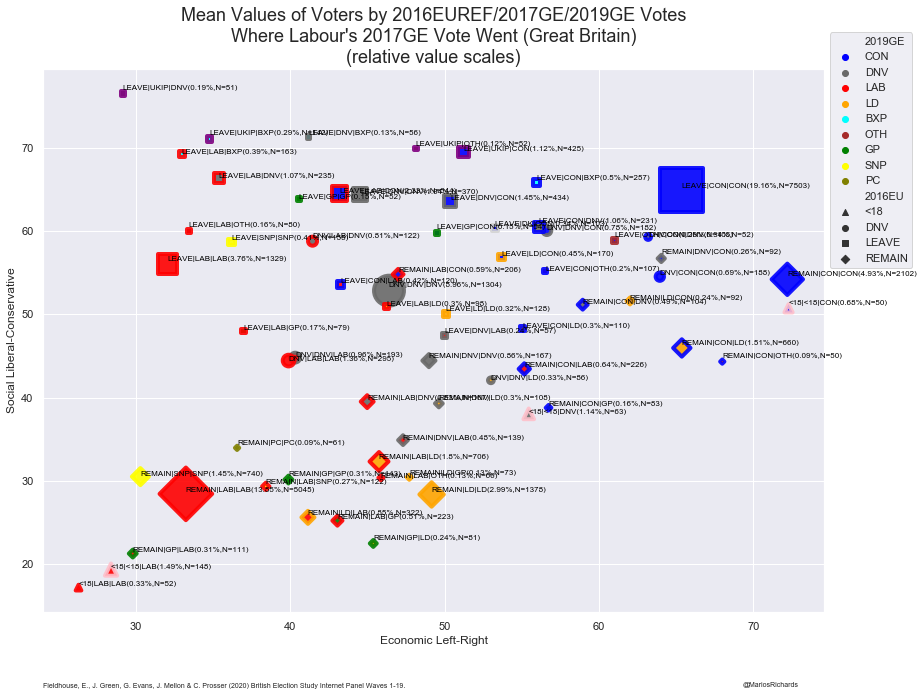

In [101]:
BES_Panel[pan_dataset_votes.columns] = pan_dataset_votes.replace("Unknown",np.nan)

title = "Mean Values of Voters by 2016EUREF/2017GE/2019GE Votes\nWhere Labour's 2017GE Vote Went (Great Britain)\n(relative value scales)"
var_list = ["2016EUVote_complete","2017GEVote_complete","2019GEVote_complete"]
best_weight_variable = 'wt_new_W19_result'
# restriction = BES_Panel["countryW19"]=="English"
restriction = None
sample_size_boost = 100
min_sample_size = 50    
    
politicluster_plot(title, var_list, best_weight_variable,restriction,sample_size_boost,min_sample_size)  

,2005GE|2010GE|2019GE,Economic Left-Right,Social Liberal-Conservative,2005GE,2010GE,2019GE,sample_size,wt_sample_perc
0,"<18|<18|CON(2.3%,N=307)",73.066430,39.779087,<18,<18,CON,307,2.30
1,"<18|<18|DNV(3.34%,N=297)",63.247598,37.386768,<18,<18,DNV,297,3.34
2,"<18|<18|LAB(5.42%,N=897)",41.105326,22.582855,<18,<18,LAB,897,5.42
3,"<18|<18|LD(1.39%,N=270)",64.382465,19.140167,<18,<18,LD,270,1.39
4,"CON|CON|CON(4.91%,N=2255)",67.077941,61.208093,CON,CON,CON,2255,4.91
5,"CON|CON|DNV(1.78%,N=325)",48.385147,56.195666,CON,CON,DNV,325,1.78
6,"CON|CON|LD(0.46%,N=210)",68.722527,46.783937,CON,CON,LD,210,0.46
7,"DNV|DNV|DNV(1.41%,N=237)",44.858943,56.830664,DNV,DNV,DNV,237,1.41
8,"LAB|CON|CON(0.57%,N=231)",53.075312,62.736831,LAB,CON,CON,231,0.57
9,"LAB|LAB|CON(4.26%,N=1815)",60.085195,61.524128,LAB,LAB,CON,1815,4.26


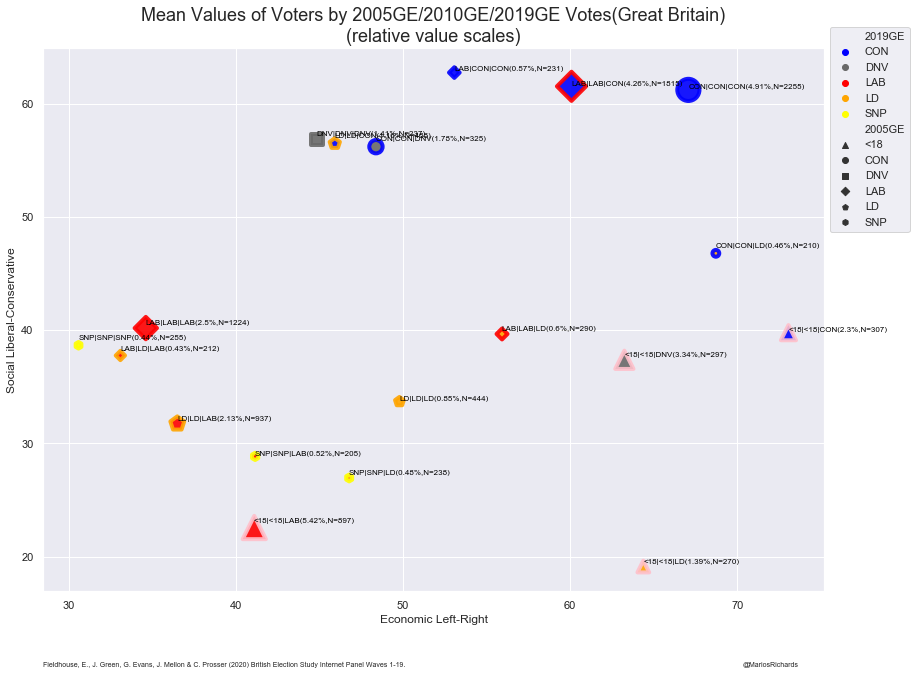

In [102]:
BES_Panel[pan_dataset_votes.columns] = pan_dataset_votes.replace("Unknown",np.nan)

title = "Mean Values of Voters by 2005GE/2010GE/2019GE Votes(Great Britain)\n(relative value scales)"
var_list = ["2005GEVote_complete","2010GEVote_complete","2019GEVote_complete"]
best_weight_variable = 'wt_new_W19_result'
# restriction = BES_Panel["countryW19"]=="English"
restriction = None
sample_size_boost = 100
min_sample_size = 200   
    
politicluster_plot(title, var_list, best_weight_variable,restriction,sample_size_boost,min_sample_size)  

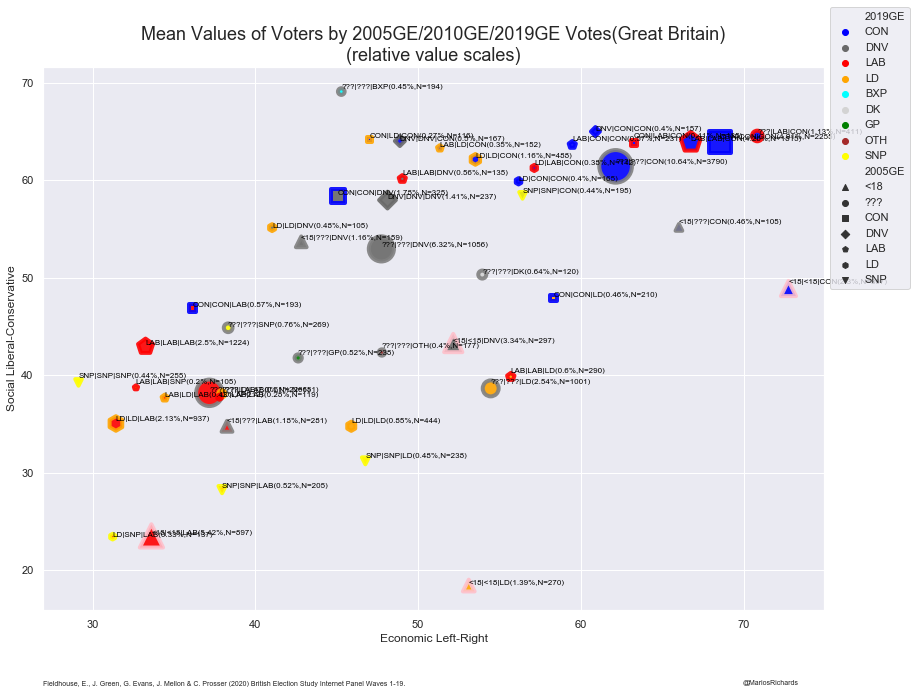

In [132]:
BES_Panel[pan_dataset_votes.columns] = pan_dataset_votes#.replace("Unknown",np.nan)

title = "Mean Values of Voters by 2005GE/2010GE/2019GE Votes(Great Britain)\n(relative value scales)"
var_list = ["2005GEVote_complete","2010GEVote_complete","2019GEVote_complete"]
best_weight_variable = 'wt_new_W19_result'
# restriction = BES_Panel["countryW19"]=="English"
restriction = None
sample_size_boost = 100
min_sample_size = 100
    
df,mask,cats = politicluster_plot(title, var_list, best_weight_variable,restriction,sample_size_boost,min_sample_size)  

In [133]:
df["sample_size"].sum(),mask.sum()

(23408, 32177)

In [134]:
df["wt_sample_perc"].sum()

74.22999999999998

In [135]:
cats.value_counts()

???|???|CON(10.64%,N=3790)    3790
???|???|LAB(7.0%,N=2266)      2266
CON|CON|CON(4.91%,N=2255)     2255
LAB|LAB|CON(4.26%,N=1815)     1815
LAB|LAB|LAB(2.5%,N=1224)      1224
???|???|DNV(6.32%,N=1056)     1056
???|???|LD(2.54%,N=1001)      1001
LD|LD|LAB(2.13%,N=937)         937
<18|<18|LAB(5.42%,N=897)       897
LD|LD|CON(1.16%,N=488)         488
LD|LD|LD(0.85%,N=444)          444
???|LAB|CON(1.13%,N=411)       411
CON|CON|DNV(1.78%,N=325)       325
<18|<18|CON(2.3%,N=307)        307
<18|<18|DNV(3.34%,N=297)       297
LAB|LAB|LD(0.6%,N=290)         290
<18|???|LAB(1.18%,N=281)       281
<18|<18|LD(1.39%,N=270)        270
???|???|SNP(0.76%,N=269)       269
SNP|SNP|SNP(0.44%,N=255)       255
???|???|GP(0.52%,N=238)        238
SNP|SNP|LD(0.48%,N=238)        238
DNV|DNV|DNV(1.41%,N=237)       237
LAB|CON|CON(0.57%,N=231)       231
LAB|LD|LAB(0.43%,N=212)        212
CON|CON|LD(0.46%,N=210)        210
SNP|SNP|LAB(0.52%,N=205)       205
SNP|SNP|CON(0.44%,N=195)       195
???|???|BXP(0.45%,N=

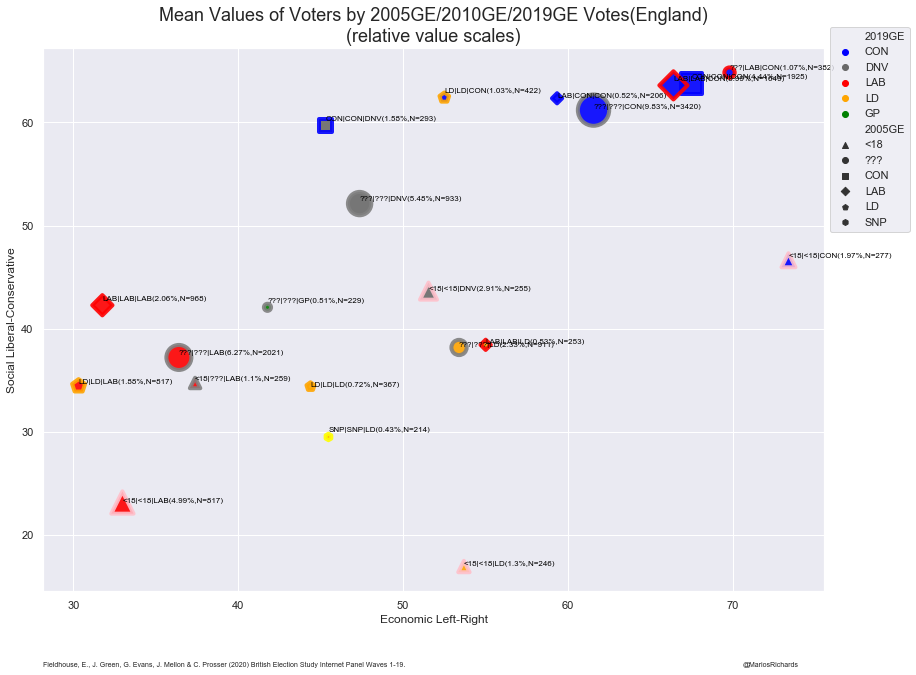

In [147]:
BES_Panel[pan_dataset_votes.columns] = pan_dataset_votes#.replace("Unknown",np.nan)

title = "Mean Values of Voters by 2005GE/2010GE/2019GE Votes(England)\n(relative value scales)"
var_list = ["2005GEVote_complete","2010GEVote_complete","2019GEVote_complete"]
best_weight_variable = 'wt_new_W19_result'
restriction = BES_Panel["countryW19"]=="English"
# restriction = None
sample_size_boost = 100
min_sample_size = 200
    
df,mask,cats = politicluster_plot(title, var_list, best_weight_variable,restriction,sample_size_boost,min_sample_size)  

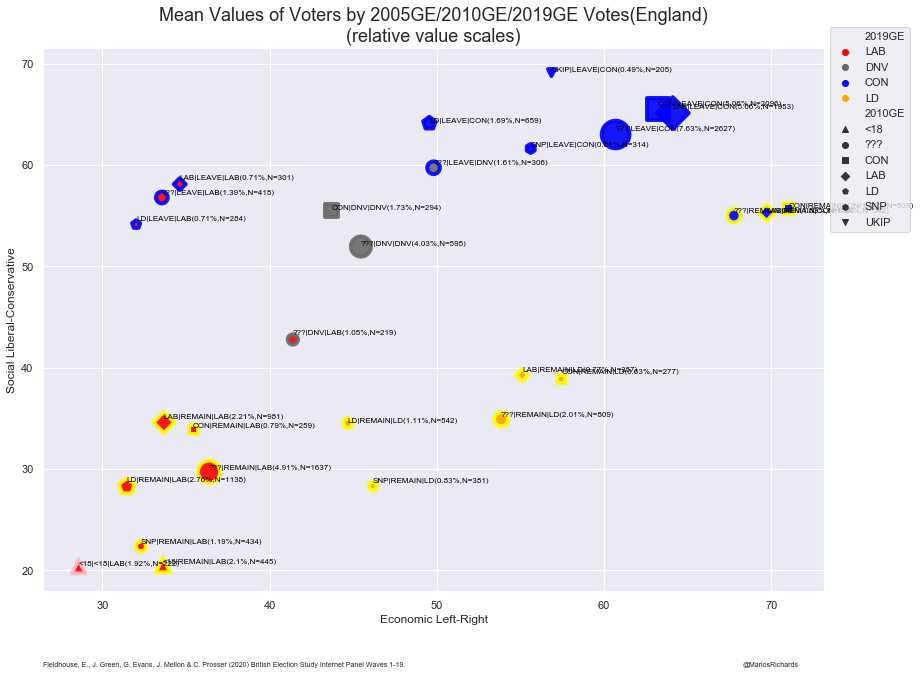

In [148]:
BES_Panel[pan_dataset_votes.columns] = pan_dataset_votes#.replace("Unknown",np.nan)

title = "Mean Values of Voters by 2005GE/2010GE/2019GE Votes(England)\n(relative value scales)"
var_list = ["2010GEVote_complete","2016EUVote_complete","2019GEVote_complete"]
best_weight_variable = 'wt_new_W19_result'
restriction = BES_Panel["countryW19"]=="English"
# restriction = None
sample_size_boost = 100
min_sample_size = 200
    
df,mask,cats = politicluster_plot(title, var_list, best_weight_variable,restriction,sample_size_boost,min_sample_size)  

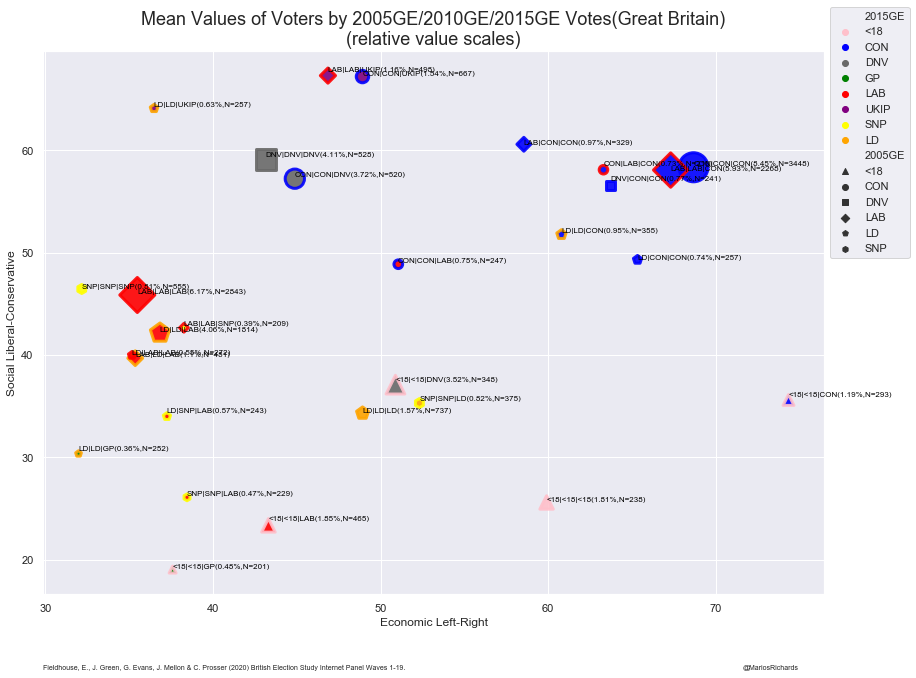

In [181]:
BES_Panel[pan_dataset_votes.columns] = pan_dataset_votes#.replace("Unknown",np.nan)

title = "Mean Values of Voters by 2005GE/2010GE/2015GE Votes(Great Britain)\n(relative value scales)"
var_list = ["2005GEVote_complete","2010GEVote_complete","2015GEVote_complete"]
best_weight_variable = 'wt_new_W8'
# restriction = BES_Panel["countryW8"]=="English"
restriction = None
sample_size_boost = 100
min_sample_size = 200
    
df,mask,cats = politicluster_plot(title, var_list, best_weight_variable,restriction,sample_size_boost,min_sample_size)  

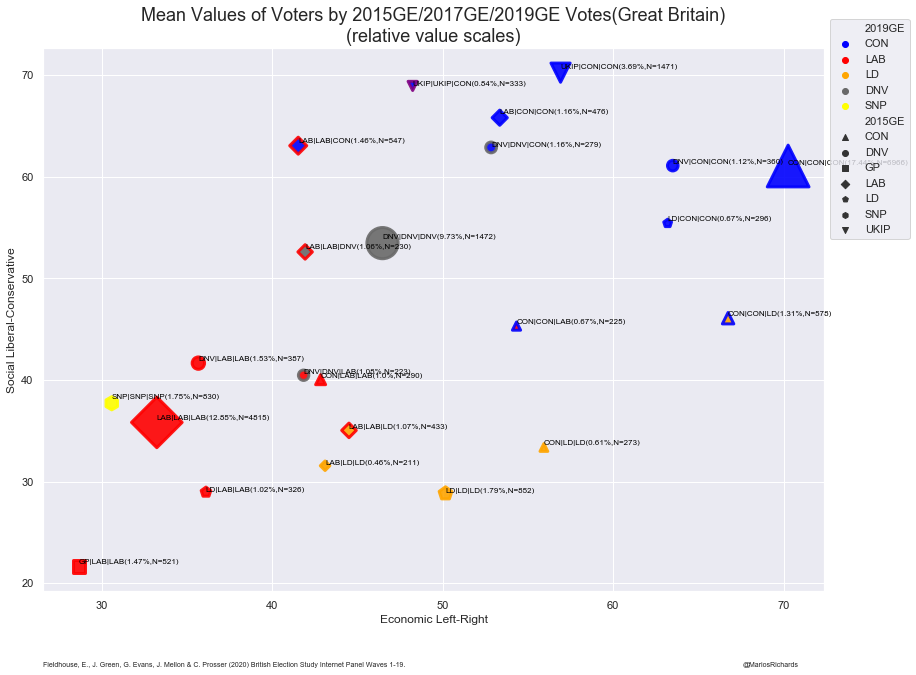

In [173]:
BES_Panel[pan_dataset_votes.columns] = pan_dataset_votes#.replace("Unknown",np.nan)

title = "Mean Values of Voters by 2015GE/2017GE/2019GE Votes(Great Britain)\n(relative value scales)"
var_list = ["2015GEVote_complete","2017GEVote_complete","2019GEVote_complete"]
best_weight_variable = 'wt_new_W19_result'
# restriction = BES_Panel["countryW8"]=="English"
restriction = None
sample_size_boost = 100
min_sample_size = 200
    
df,mask,cats = politicluster_plot(title, var_list, best_weight_variable,restriction,sample_size_boost,min_sample_size)  

In [191]:
search(BES_Panel,"wt_.*W5")

wt_daily_W5                   30725
wt_full_W5                    30725
wt_full_W1W2W3W4W5            17673
wt_full_W4W5                  28096
wt_full_W1W2W3W4W5W6          16807
wt_full_W4W5W6                26144
wt_full_W1W2W3W4W5W6W7W8      11411
wt_full_W1W2W3W4W5W6W7W8W9    10172
wt_full_W1W2W3W4W5W6W7        13313
dtype: int64

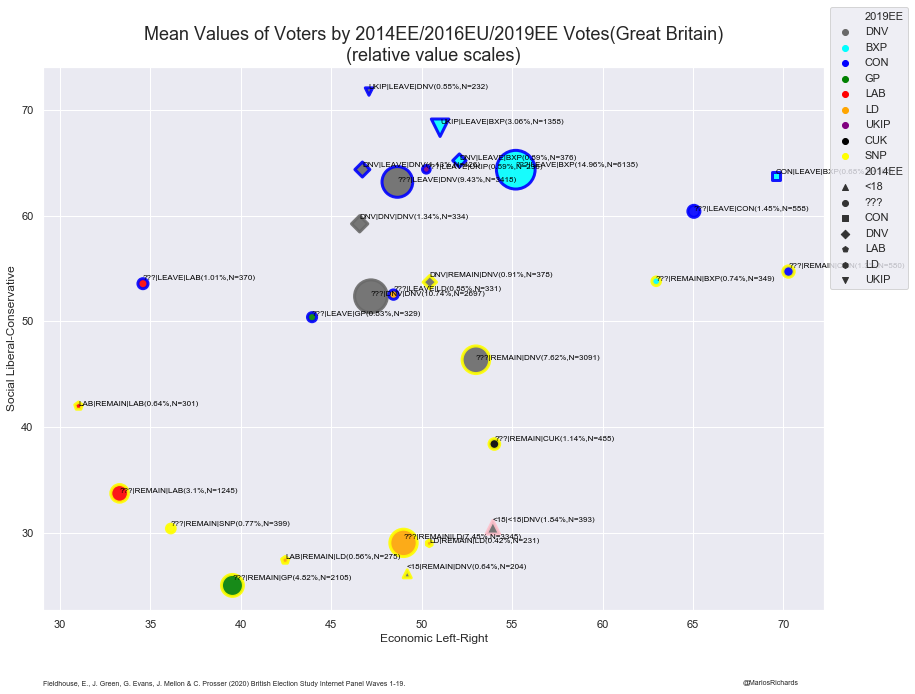

In [190]:
BES_Panel[pan_dataset_votes.columns] = pan_dataset_votes#.replace("Unknown",np.nan)

title = "Mean Values of Voters by 2014EE/2016EU/2019EE Votes(Great Britain)\n(relative value scales)"
var_list = ["2014EEVote_complete","2016EUVote_complete","2019EEVote_complete"]
best_weight_variable = 'wt_new_W16'
# restriction = BES_Panel["countryW8"]=="English"
restriction = None
sample_size_boost = 100
min_sample_size = 200
    
df,mask,cats = politicluster_plot(title, var_list, best_weight_variable,restriction,sample_size_boost,min_sample_size)  

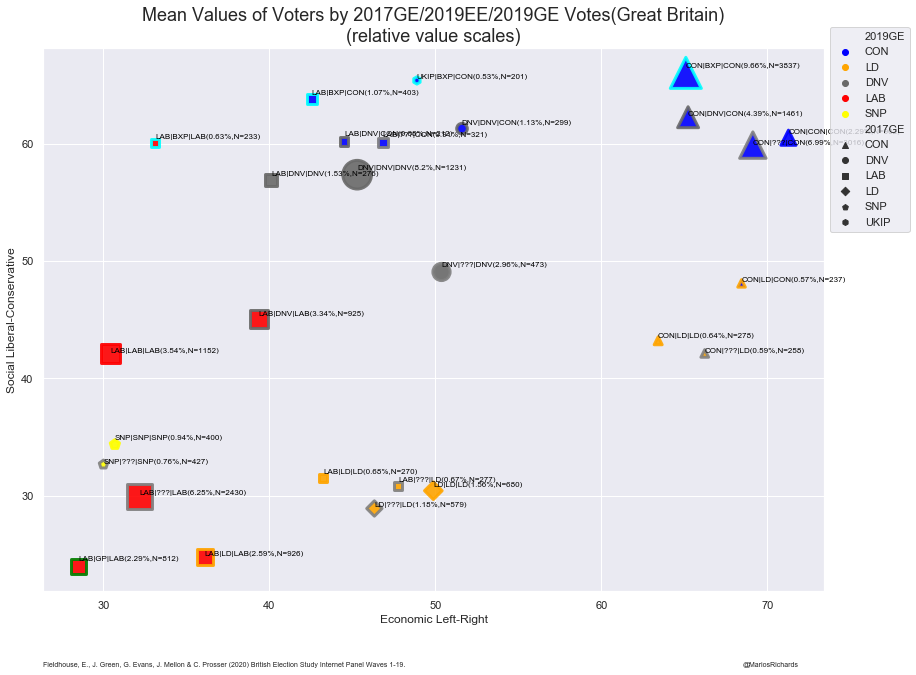

In [186]:
BES_Panel[pan_dataset_votes.columns] = pan_dataset_votes#.replace("Unknown",np.nan)

title = "Mean Values of Voters by 2017GE/2019EE/2019GE Votes(Great Britain)\n(relative value scales)"
var_list = ["2017GEVote_complete","2019EEVote_complete","2019GEVote_complete"]
best_weight_variable = 'wt_new_W19_result'
# restriction = BES_Panel["countryW8"]=="English"
restriction = None
sample_size_boost = 100
min_sample_size = 200
    
df,mask,cats = politicluster_plot(title, var_list, best_weight_variable,restriction,sample_size_boost,min_sample_size)  

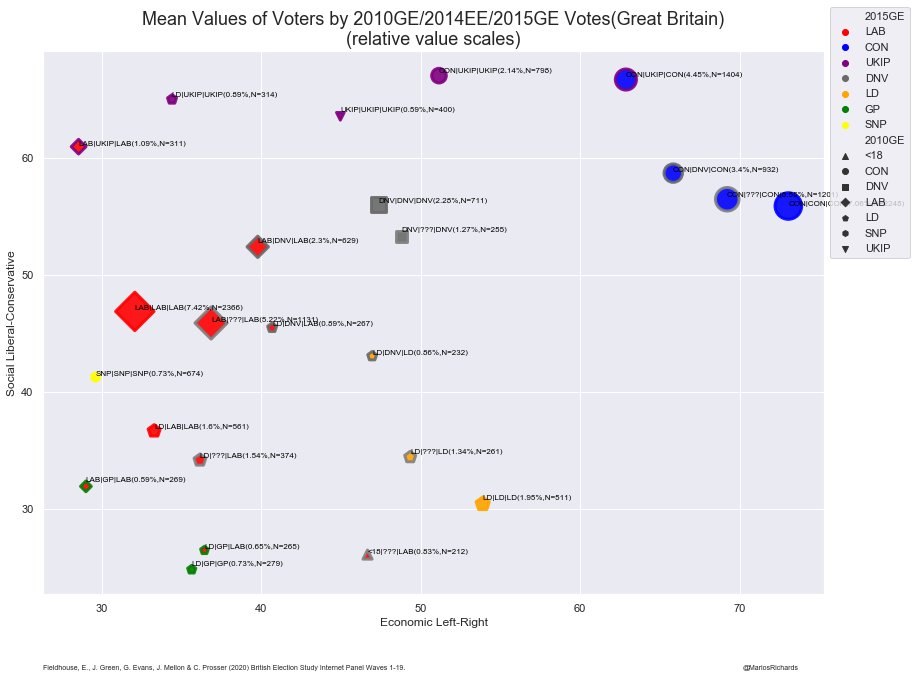

In [192]:
BES_Panel[pan_dataset_votes.columns] = pan_dataset_votes#.replace("Unknown",np.nan)

title = "Mean Values of Voters by 2010GE/2014EE/2015GE Votes(Great Britain)\n(relative value scales)"
var_list = ["2010GEVote_complete","2014EEVote_complete","2015GEVote_complete"]
best_weight_variable = 'wt_full_W5'
# restriction = BES_Panel["countryW8"]=="English"
restriction = None
sample_size_boost = 100
min_sample_size = 200
    
df,mask,cats = politicluster_plot(title, var_list, best_weight_variable,restriction,sample_size_boost,min_sample_size)  

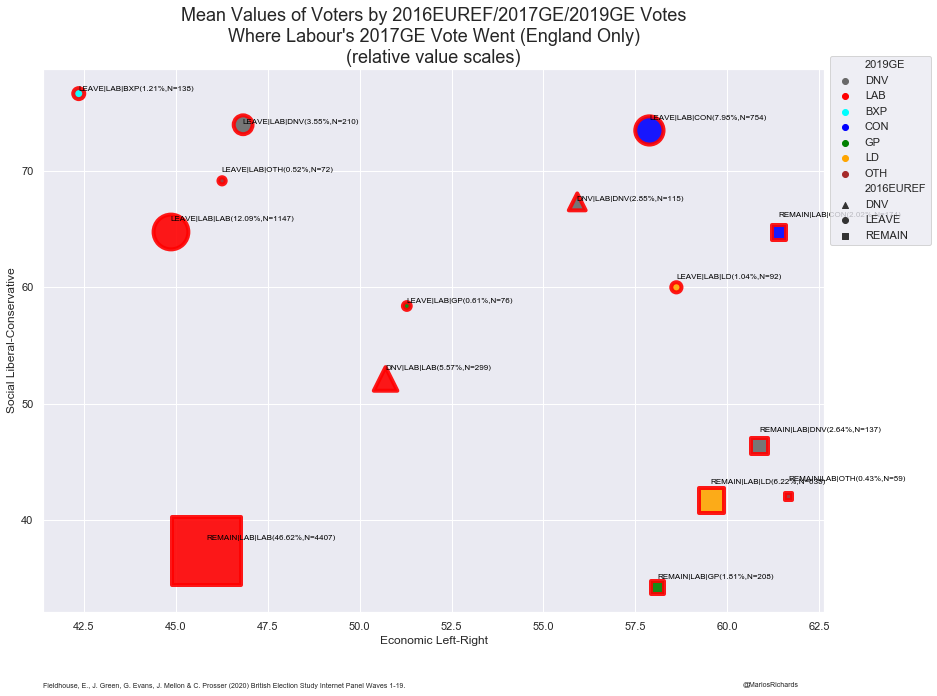

In [51]:
# %%time
# cat_variable = "profile_past_vote_2015"


# mask = BES_Panel["profile_eurefvote"].notnull() & BES_Panel["profile_past_vote_2017"].notnull() & BES_Panel["euroElectionVoteW16"].notnull()
# cats = BES_Panel["profile_eurefvote"].map(replace_dict).astype(str)+"|"+BES_Panel["profile_past_vote_2017"].map(replace_dict).astype(str)+"|"+BES_Panel["euroElectionVoteW16"].map(replace_dict).astype(str)
# cats[~mask] = np.nan
# cats = cats.astype('category')

# # cats = BES_Panel[cat_variable]
# cat_sample_sizes = cats.value_counts()

# cats.cat.remove_categories(cat_sample_sizes[cat_sample_sizes<200].index,inplace=True)

# cats = cats.apply(lambda x: x+"(N="+str(cat_sample_sizes.loc[x])+")")


title = "Mean Values of Voters by 2016EUREF/2017GE/2019GE-VI\n(England Only)\n(Normalised Political Compass)\n(Voronoi Overlap)"
# fig = plt.figure(figsize=(14,10))
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)

restriction = (BES_Panel["countryW19"]=="English") & (BES_Panel["profile_past_vote_2017"]=="Labour")
# restriction = None
sample_size_boost=100
min_sample_size = 50

BES = BES_Panel
if restriction is None:
#     BES = BES_Panel
    specific_mask = 1
else:
#     BES = BES_Panel[restriction]
    specific_mask = restriction
# BES = BES_Panel

var_list = ["2016EUVote_complete","2017GEVote_complete","2019GEVote_complete"]
exposed_final_vote_name = "2019GE-VI"


best_weight_variable = 'wt_new_W19_result'
wts = BES_Panel[best_weight_variable].copy()
if restriction is not None:
    wts[~specific_mask] = np.nan


mask = BES[var_list].notnull().all(axis=1) & specific_mask
cats = BES[var_list].apply(lambda x: x.map(replace_dict)).astype(str).apply(lambda x: "|".join(x),axis=1)
# mask = BES_Panel["profile_eurefvote"].notnull() & BES_Panel["profile_past_vote_2017"].notnull() & BES_Panel["euroElectionVoteW16"].notnull()
# cats = BES_Panel["profile_eurefvote"].map(replace_dict).astype(str)+"|"+BES_Panel["profile_past_vote_2017"].map(replace_dict).astype(str)+"|"+BES_Panel["euroElectionVoteW16"].map(replace_dict).astype(str)
cats[~mask] = np.nan
cats = cats.astype('category')

# cats = BES_Panel[cat_variable]
cat_sample_sizes = cats.value_counts()
weighted_perc = round(weighted_value_counts(cats,wts,normalize=True, perc=True)["weighted_sample_percentage"],2).apply(lambda x: str(x) +"%"  )

cats.cat.remove_categories(cat_sample_sizes[cat_sample_sizes<min_sample_size].index,inplace=True)

cats = cats.apply(lambda x: x+"("+weighted_perc.loc[x]+",N="+str(cat_sample_sizes.loc[x])+")")


# cats = cats.apply(lambda x: x if x in cat_sample_sizes[cat_sample_sizes>500].index else np.nan).astype('category')

best_al_scale_variable = search(BES_Panel,"al_scale",mask=cats.notnull()).sort_values(ascending=False).index[0]
best_lr_scale_variable = search(BES_Panel,"lr_scale",mask=cats.notnull()).sort_values(ascending=False).index[0]

# best_weight_variable = search(BES_Panel,"wt_",mask=BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan).notnull()).sort_values(ascending=False).index[0]


al_mask = BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan).notnull() & wts.notnull() & mask
euro_election_al = pd.crosstab(index   = cats,
                       columns = weighted_qcut(BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan)[al_mask],
                                               wts[al_mask],100).cat.codes,
                       values  = wts[al_mask],
                       aggfunc = sum,
                       normalize='index')
euro_election_al = euro_election_al.apply(lambda x: sum(x*euro_election_al.columns),axis=1)
lr_mask = BES_Panel[best_lr_scale_variable].cat.codes.replace(-1,np.nan).notnull() & wts.notnull()&mask
euro_election_lr = pd.crosstab(index   = cats,
                       columns = weighted_qcut(BES_Panel[best_lr_scale_variable].cat.codes.replace(-1,np.nan)[lr_mask],
                                               wts[lr_mask],100).cat.codes,
                       values  = wts[lr_mask],
                       aggfunc = sum,
                       normalize='index')
euro_election_lr = euro_election_lr.apply(lambda x: sum(x*euro_election_lr.columns),axis=1)

# euro_election_al = BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan).groupby(cats).mean()
# euro_election_lr = BES_Panel[best_lr_scale_variable].cat.codes.replace(-1,np.nan).groupby(cats).mean()

df = pd.concat([euro_election_lr,euro_election_al],axis=1).reset_index()
cat_name ="2016EUREF|2017GE|2019GE"
lr_scale_name = "Economic Left-Right"
al_scale_name = "Social Liberal-Conservative"
df.columns = [cat_name,lr_scale_name,al_scale_name]

df["2016EUREF"] = df[cat_name].apply(lambda x: x.split("|")[0])
df["2017GE"] = df[cat_name].apply(lambda x: x.split("|")[1])
df["2019GE"] = df[cat_name].apply(lambda x: x.split("|")[2].split("(")[0])
df["sample_size"] = df[cat_name].apply(lambda x: int(x.split("|")[2].split("=")[1].split(")")[0]) )
df["wt_sample_perc"] = df[cat_name].apply(lambda x: float(x.split("|")[2].split("(")[1].split("%")[0]) ).astype('float')

# df = df.drop(0)
from itertools import cycle
filled_markers = cycle(['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X'])
# plt.figure(figsize=(14,10))
sct = sns.scatterplot(data=df,x=lr_scale_name,y=al_scale_name, 
                hue="2019GE" ,palette = colourmap,style="2016EUREF", markers = ['^','o','s','D'],
                linewidth=4,edgecolor = df["2017GE"].map(colourmap), s = df["wt_sample_perc"]*sample_size_boost,
                alpha=.9)
#                 label=df[cat_name])
# s=1000,                
                
#                 style=cat_name,
#                 markers=filled_markers);
#                 size="size");
plt.title("Mean Values of Voters by 2016EUREF/2017GE/2019GE Votes\nWhere Labour's 2017GE Vote Went (England Only)\n(relative value scales)", fontsize=18);

for line in range(0,df.shape[0]):
     sct.text(df[lr_scale_name][line]-0.01, df[al_scale_name][line]+np.random.rand()*2, 
     df[cat_name][line], horizontalalignment='left', 
     size=8, color='black')#, weight='semibold')

plt.legend(loc='center left', bbox_to_anchor=(1, .85))        
# lgnd = plt.legend(title='Smoker', loc='upper left')
# lgnd.legendHandles[0]._sizes = [30]
# lgnd.legendHandles[1]._sizes = [30]
# plt.show()
# plt.gca().legend()
sct.annotate(dataset_citation, (0,0), (0, -70),
                 xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ; 
sct.annotate("@MariosRichards", (0,0), (700, -70),
                 xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ; 

In [ ]:
# %%time
# cat_variable = "profile_past_vote_2015"


# mask = BES_Panel["profile_eurefvote"].notnull() & BES_Panel["profile_past_vote_2017"].notnull() & BES_Panel["euroElectionVoteW16"].notnull()
# cats = BES_Panel["profile_eurefvote"].map(replace_dict).astype(str)+"|"+BES_Panel["profile_past_vote_2017"].map(replace_dict).astype(str)+"|"+BES_Panel["euroElectionVoteW16"].map(replace_dict).astype(str)
# cats[~mask] = np.nan
# cats = cats.astype('category')

# # cats = BES_Panel[cat_variable]
# cat_sample_sizes = cats.value_counts()

# cats.cat.remove_categories(cat_sample_sizes[cat_sample_sizes<200].index,inplace=True)

# cats = cats.apply(lambda x: x+"(N="+str(cat_sample_sizes.loc[x])+")")


title = "Mean Values of Voters by 2016EUREF/2017GE/2019GE-VI\n(England Only)\n(Normalised Political Compass)\n(Voronoi Overlap)"
# fig = plt.figure(figsize=(14,10))
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)

restriction = (BES_Panel["countryW19"]=="English") & (BES_Panel["profile_past_vote_2017"]=="Labour")
# restriction = None
sample_size_boost=100
min_sample_size = 100

BES = BES_Panel
if restriction is None:
#     BES = BES_Panel
    specific_mask = 1
else:
#     BES = BES_Panel[restriction]
    specific_mask = restriction
# BES = BES_Panel

var_list = ["profile_eurefvote","profile_past_vote_2017","pastvote_ge_2019W19"]
exposed_final_vote_name = "2019GE-VI"


best_weight_variable = 'wt_new_W19_result'
wts = BES_Panel[best_weight_variable].copy()
if restriction is not None:
    wts[~specific_mask] = np.nan


mask = BES[var_list].notnull().all(axis=1) & specific_mask
cats = BES[var_list].apply(lambda x: x.map(replace_dict)).astype(str).apply(lambda x: "|".join(x),axis=1)
# mask = BES_Panel["profile_eurefvote"].notnull() & BES_Panel["profile_past_vote_2017"].notnull() & BES_Panel["euroElectionVoteW16"].notnull()
# cats = BES_Panel["profile_eurefvote"].map(replace_dict).astype(str)+"|"+BES_Panel["profile_past_vote_2017"].map(replace_dict).astype(str)+"|"+BES_Panel["euroElectionVoteW16"].map(replace_dict).astype(str)
cats[~mask] = np.nan
cats = cats.astype('category')

# cats = BES_Panel[cat_variable]
cat_sample_sizes = cats.value_counts()
weighted_perc = round(weighted_value_counts(cats,wts,normalize=True, perc=True)["weighted_sample_percentage"],2).apply(lambda x: str(x) +"%"  )

cats.cat.remove_categories(cat_sample_sizes[cat_sample_sizes<min_sample_size].index,inplace=True)

cats = cats.apply(lambda x: x+"("+weighted_perc.loc[x]+",N="+str(cat_sample_sizes.loc[x])+")")


# cats = cats.apply(lambda x: x if x in cat_sample_sizes[cat_sample_sizes>500].index else np.nan).astype('category')

best_al_scale_variable = search(BES_Panel,"al_scale",mask=cats.notnull()).sort_values(ascending=False).index[0]
best_lr_scale_variable = search(BES_Panel,"lr_scale",mask=cats.notnull()).sort_values(ascending=False).index[0]

# best_weight_variable = search(BES_Panel,"wt_",mask=BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan).notnull()).sort_values(ascending=False).index[0]


al_mask = BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan).notnull() & wts.notnull() & mask
euro_election_al = pd.crosstab(index   = cats,
                       columns = weighted_qcut(BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan)[al_mask],
                                               wts[al_mask],100).cat.codes,
                       values  = wts[al_mask],
                       aggfunc = sum,
                       normalize='index')
euro_election_al = euro_election_al.apply(lambda x: sum(x*euro_election_al.columns),axis=1)
lr_mask = BES_Panel[best_lr_scale_variable].cat.codes.replace(-1,np.nan).notnull() & wts.notnull()&mask
euro_election_lr = pd.crosstab(index   = cats,
                       columns = weighted_qcut(BES_Panel[best_lr_scale_variable].cat.codes.replace(-1,np.nan)[lr_mask],
                                               wts[lr_mask],100).cat.codes,
                       values  = wts[lr_mask],
                       aggfunc = sum,
                       normalize='index')
euro_election_lr = euro_election_lr.apply(lambda x: sum(x*euro_election_lr.columns),axis=1)

# euro_election_al = BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan).groupby(cats).mean()
# euro_election_lr = BES_Panel[best_lr_scale_variable].cat.codes.replace(-1,np.nan).groupby(cats).mean()

df = pd.concat([euro_election_lr,euro_election_al],axis=1).reset_index()
cat_name ="2016EUREF|2017GE|2019GE"
lr_scale_name = "Economic Left-Right"
al_scale_name = "Social Liberal-Conservative"
df.columns = [cat_name,lr_scale_name,al_scale_name]

df["2016EUREF"] = df[cat_name].apply(lambda x: x.split("|")[0])
df["2017GE"] = df[cat_name].apply(lambda x: x.split("|")[1])
df["2019GE"] = df[cat_name].apply(lambda x: x.split("|")[2].split("(")[0])
df["sample_size"] = df[cat_name].apply(lambda x: int(x.split("|")[2].split("=")[1].split(")")[0]) )
df["wt_sample_perc"] = df[cat_name].apply(lambda x: float(x.split("|")[2].split("(")[1].split("%")[0]) ).astype('float')

# df = df.drop(0)
from itertools import cycle
filled_markers = cycle(['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X'])
# plt.figure(figsize=(14,10))
sct = sns.scatterplot(data=df,x=lr_scale_name,y=al_scale_name, 
                hue="2019GE" ,palette = colourmap,style="2016EUREF", markers = ['^','o','s','D'],
                linewidth=4,edgecolor = df["2017GE"].map(colourmap), s = df["wt_sample_perc"]*sample_size_boost,
                alpha=.9)
#                 label=df[cat_name])
# s=1000,                
                
#                 style=cat_name,
#                 markers=filled_markers);
#                 size="size");
plt.title("Mean Values of Voters by 2016EUREF/2017GE/2019GE Votes\nWhere Labour's 2017GE Vote Went (England Only)\n(relative value scales)", fontsize=18);

for line in range(0,df.shape[0]):
     sct.text(df[lr_scale_name][line]-0.01, df[al_scale_name][line]+np.random.rand()*2, 
     df[cat_name][line], horizontalalignment='left', 
     size=8, color='black')#, weight='semibold')

plt.legend(loc='center left', bbox_to_anchor=(1, .85))        
# lgnd = plt.legend(title='Smoker', loc='upper left')
# lgnd.legendHandles[0]._sizes = [30]
# lgnd.legendHandles[1]._sizes = [30]
# plt.show()
# plt.gca().legend()
sct.annotate(dataset_citation, (0,0), (0, -70),
                 xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ; 
sct.annotate("@MariosRichards", (0,0), (700, -70),
                 xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ; 

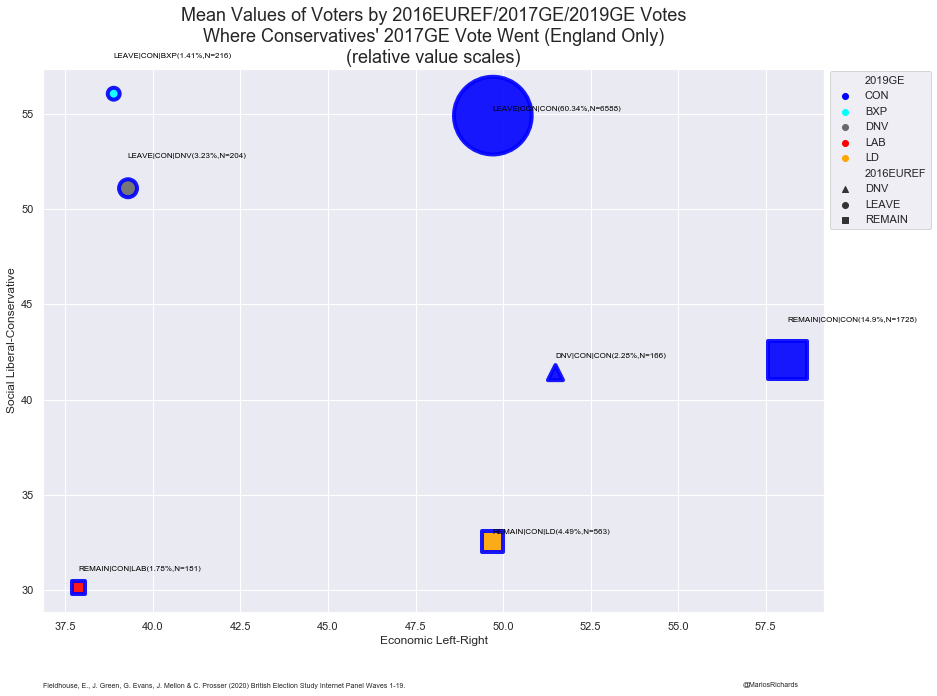

In [252]:
# %%time
# cat_variable = "profile_past_vote_2015"


# mask = BES_Panel["profile_eurefvote"].notnull() & BES_Panel["profile_past_vote_2017"].notnull() & BES_Panel["euroElectionVoteW16"].notnull()
# cats = BES_Panel["profile_eurefvote"].map(replace_dict).astype(str)+"|"+BES_Panel["profile_past_vote_2017"].map(replace_dict).astype(str)+"|"+BES_Panel["euroElectionVoteW16"].map(replace_dict).astype(str)
# cats[~mask] = np.nan
# cats = cats.astype('category')

# # cats = BES_Panel[cat_variable]
# cat_sample_sizes = cats.value_counts()

# cats.cat.remove_categories(cat_sample_sizes[cat_sample_sizes<200].index,inplace=True)

# cats = cats.apply(lambda x: x+"(N="+str(cat_sample_sizes.loc[x])+")")


title = "Mean Values of Voters by 2016EUREF/2017GE/2019GE-VI\n(England Only)\n(Normalised Political Compass)\n(Voronoi Overlap)"
# fig = plt.figure(figsize=(14,10))
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)

restriction = (BES_Panel["countryW19"]=="English") & (BES_Panel["profile_past_vote_2017"]=="Conservative")
# restriction = None
sample_size_boost=100
min_sample_size = 100

BES = BES_Panel
if restriction is None:
#     BES = BES_Panel
    specific_mask = 1
else:
#     BES = BES_Panel[restriction]
    specific_mask = restriction
# BES = BES_Panel

var_list = ["profile_eurefvote","profile_past_vote_2017","pastvote_ge_2019W19"]
exposed_final_vote_name = "2019GE-VI"


best_weight_variable = 'wt_new_W19_result'
wts = BES_Panel[best_weight_variable].copy()
if restriction is not None:
    wts[~specific_mask] = np.nan


mask = BES[var_list].notnull().all(axis=1) & specific_mask
cats = BES[var_list].apply(lambda x: x.map(replace_dict)).astype(str).apply(lambda x: "|".join(x),axis=1)
# mask = BES_Panel["profile_eurefvote"].notnull() & BES_Panel["profile_past_vote_2017"].notnull() & BES_Panel["euroElectionVoteW16"].notnull()
# cats = BES_Panel["profile_eurefvote"].map(replace_dict).astype(str)+"|"+BES_Panel["profile_past_vote_2017"].map(replace_dict).astype(str)+"|"+BES_Panel["euroElectionVoteW16"].map(replace_dict).astype(str)
cats[~mask] = np.nan
cats = cats.astype('category')

# cats = BES_Panel[cat_variable]
cat_sample_sizes = cats.value_counts()
weighted_perc = round(weighted_value_counts(cats,wts,normalize=True, perc=True)["weighted_sample_percentage"],2).apply(lambda x: str(x) +"%"  )

cats.cat.remove_categories(cat_sample_sizes[cat_sample_sizes<min_sample_size].index,inplace=True)

cats = cats.apply(lambda x: x+"("+weighted_perc.loc[x]+",N="+str(cat_sample_sizes.loc[x])+")")


# cats = cats.apply(lambda x: x if x in cat_sample_sizes[cat_sample_sizes>500].index else np.nan).astype('category')

best_al_scale_variable = search(BES_Panel,"al_scale",mask=cats.notnull()).sort_values(ascending=False).index[0]
best_lr_scale_variable = search(BES_Panel,"lr_scale",mask=cats.notnull()).sort_values(ascending=False).index[0]

# best_weight_variable = search(BES_Panel,"wt_",mask=BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan).notnull()).sort_values(ascending=False).index[0]


al_mask = BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan).notnull() & wts.notnull() & mask
euro_election_al = pd.crosstab(index   = cats,
                       columns = weighted_qcut(BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan)[al_mask],
                                               wts[al_mask],100).cat.codes,
                       values  = wts[al_mask],
                       aggfunc = sum,
                       normalize='index')
euro_election_al = euro_election_al.apply(lambda x: sum(x*euro_election_al.columns),axis=1)
lr_mask = BES_Panel[best_lr_scale_variable].cat.codes.replace(-1,np.nan).notnull() & wts.notnull()&mask
euro_election_lr = pd.crosstab(index   = cats,
                       columns = weighted_qcut(BES_Panel[best_lr_scale_variable].cat.codes.replace(-1,np.nan)[lr_mask],
                                               wts[lr_mask],100).cat.codes,
                       values  = wts[lr_mask],
                       aggfunc = sum,
                       normalize='index')
euro_election_lr = euro_election_lr.apply(lambda x: sum(x*euro_election_lr.columns),axis=1)

# euro_election_al = BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan).groupby(cats).mean()
# euro_election_lr = BES_Panel[best_lr_scale_variable].cat.codes.replace(-1,np.nan).groupby(cats).mean()

df = pd.concat([euro_election_lr,euro_election_al],axis=1).reset_index()
cat_name ="2016EUREF|2017GE|2019GE"
lr_scale_name = "Economic Left-Right"
al_scale_name = "Social Liberal-Conservative"
df.columns = [cat_name,lr_scale_name,al_scale_name]

df["2016EUREF"] = df[cat_name].apply(lambda x: x.split("|")[0])
df["2017GE"] = df[cat_name].apply(lambda x: x.split("|")[1])
df["2019GE"] = df[cat_name].apply(lambda x: x.split("|")[2].split("(")[0])
df["sample_size"] = df[cat_name].apply(lambda x: int(x.split("|")[2].split("=")[1].split(")")[0]) )
df["wt_sample_perc"] = df[cat_name].apply(lambda x: float(x.split("|")[2].split("(")[1].split("%")[0]) ).astype('float')

# df = df.drop(0)
from itertools import cycle
filled_markers = cycle(['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X'])
# plt.figure(figsize=(14,10))
sct = sns.scatterplot(data=df,x=lr_scale_name,y=al_scale_name, 
                hue="2019GE" ,palette = colourmap,style="2016EUREF", markers = ['^','o','s','D'],
                linewidth=4,edgecolor = df["2017GE"].map(colourmap), s = df["wt_sample_perc"]*sample_size_boost,
                alpha=.9)
#                 label=df[cat_name])
# s=1000,                
                
#                 style=cat_name,
#                 markers=filled_markers);
#                 size="size");
plt.title("Mean Values of Voters by 2016EUREF/2017GE/2019GE Votes\nWhere Conservatives' 2017GE Vote Went (England Only)\n(relative value scales)", fontsize=18);

for line in range(0,df.shape[0]):
     sct.text(df[lr_scale_name][line]-0.01, df[al_scale_name][line]+np.random.rand()*2, 
     df[cat_name][line], horizontalalignment='left', 
     size=8, color='black')#, weight='semibold')

plt.legend(loc='center left', bbox_to_anchor=(1, .85))        
# lgnd = plt.legend(title='Smoker', loc='upper left')
# lgnd.legendHandles[0]._sizes = [30]
# lgnd.legendHandles[1]._sizes = [30]
# plt.show()
# plt.gca().legend()
sct.annotate(dataset_citation, (0,0), (0, -70),
                 xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ; 
sct.annotate("@MariosRichards", (0,0), (700, -70),
                 xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ; 

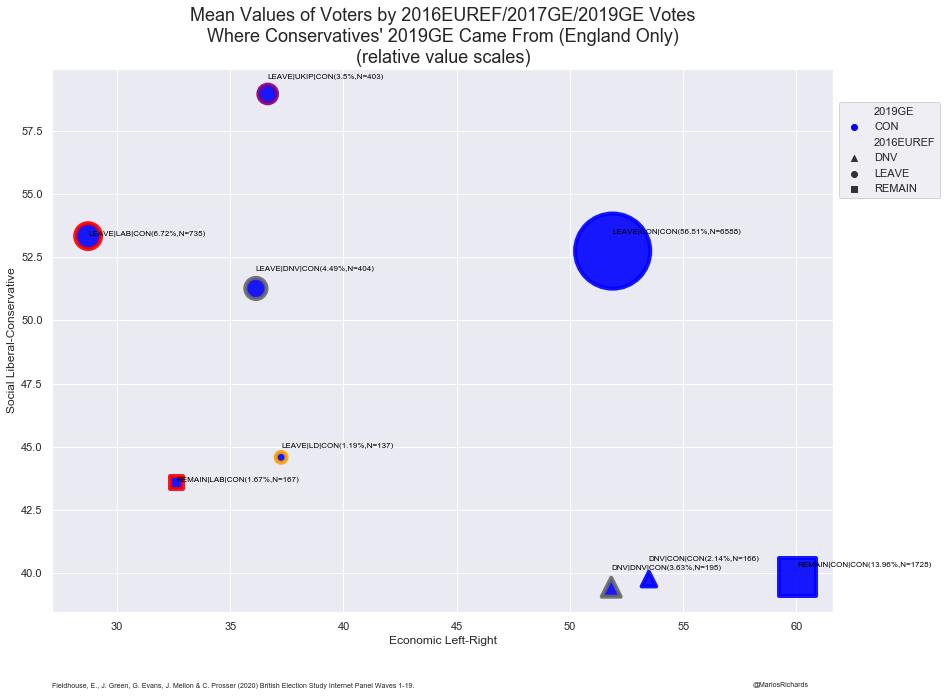

In [254]:
# %%time
# cat_variable = "profile_past_vote_2015"


# mask = BES_Panel["profile_eurefvote"].notnull() & BES_Panel["profile_past_vote_2017"].notnull() & BES_Panel["euroElectionVoteW16"].notnull()
# cats = BES_Panel["profile_eurefvote"].map(replace_dict).astype(str)+"|"+BES_Panel["profile_past_vote_2017"].map(replace_dict).astype(str)+"|"+BES_Panel["euroElectionVoteW16"].map(replace_dict).astype(str)
# cats[~mask] = np.nan
# cats = cats.astype('category')

# # cats = BES_Panel[cat_variable]
# cat_sample_sizes = cats.value_counts()

# cats.cat.remove_categories(cat_sample_sizes[cat_sample_sizes<200].index,inplace=True)

# cats = cats.apply(lambda x: x+"(N="+str(cat_sample_sizes.loc[x])+")")


title = "Mean Values of Voters by 2016EUREF/2017GE/2019GE-VI\n(England Only)\n(Normalised Political Compass)\n(Voronoi Overlap)"
# fig = plt.figure(figsize=(14,10))
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)

restriction = (BES_Panel["countryW19"]=="English") & (BES_Panel["pastvote_ge_2019W19"]=="Conservative")
# restriction = None
sample_size_boost=100
min_sample_size = 100

BES = BES_Panel
if restriction is None:
#     BES = BES_Panel
    specific_mask = 1
else:
#     BES = BES_Panel[restriction]
    specific_mask = restriction
# BES = BES_Panel

var_list = ["profile_eurefvote","profile_past_vote_2017","pastvote_ge_2019W19"]
exposed_final_vote_name = "2019GE-VI"


best_weight_variable = 'wt_new_W19_result'
wts = BES_Panel[best_weight_variable].copy()
if restriction is not None:
    wts[~specific_mask] = np.nan


mask = BES[var_list].notnull().all(axis=1) & specific_mask
cats = BES[var_list].apply(lambda x: x.map(replace_dict)).astype(str).apply(lambda x: "|".join(x),axis=1)
# mask = BES_Panel["profile_eurefvote"].notnull() & BES_Panel["profile_past_vote_2017"].notnull() & BES_Panel["euroElectionVoteW16"].notnull()
# cats = BES_Panel["profile_eurefvote"].map(replace_dict).astype(str)+"|"+BES_Panel["profile_past_vote_2017"].map(replace_dict).astype(str)+"|"+BES_Panel["euroElectionVoteW16"].map(replace_dict).astype(str)
cats[~mask] = np.nan
cats = cats.astype('category')

# cats = BES_Panel[cat_variable]
cat_sample_sizes = cats.value_counts()
weighted_perc = round(weighted_value_counts(cats,wts,normalize=True, perc=True)["weighted_sample_percentage"],2).apply(lambda x: str(x) +"%"  )

cats.cat.remove_categories(cat_sample_sizes[cat_sample_sizes<min_sample_size].index,inplace=True)

cats = cats.apply(lambda x: x+"("+weighted_perc.loc[x]+",N="+str(cat_sample_sizes.loc[x])+")")


# cats = cats.apply(lambda x: x if x in cat_sample_sizes[cat_sample_sizes>500].index else np.nan).astype('category')

best_al_scale_variable = search(BES_Panel,"al_scale",mask=cats.notnull()).sort_values(ascending=False).index[0]
best_lr_scale_variable = search(BES_Panel,"lr_scale",mask=cats.notnull()).sort_values(ascending=False).index[0]

# best_weight_variable = search(BES_Panel,"wt_",mask=BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan).notnull()).sort_values(ascending=False).index[0]


al_mask = BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan).notnull() & wts.notnull() & mask
euro_election_al = pd.crosstab(index   = cats,
                       columns = weighted_qcut(BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan)[al_mask],
                                               wts[al_mask],100).cat.codes,
                       values  = wts[al_mask],
                       aggfunc = sum,
                       normalize='index')
euro_election_al = euro_election_al.apply(lambda x: sum(x*euro_election_al.columns),axis=1)
lr_mask = BES_Panel[best_lr_scale_variable].cat.codes.replace(-1,np.nan).notnull() & wts.notnull()&mask
euro_election_lr = pd.crosstab(index   = cats,
                       columns = weighted_qcut(BES_Panel[best_lr_scale_variable].cat.codes.replace(-1,np.nan)[lr_mask],
                                               wts[lr_mask],100).cat.codes,
                       values  = wts[lr_mask],
                       aggfunc = sum,
                       normalize='index')
euro_election_lr = euro_election_lr.apply(lambda x: sum(x*euro_election_lr.columns),axis=1)

# euro_election_al = BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan).groupby(cats).mean()
# euro_election_lr = BES_Panel[best_lr_scale_variable].cat.codes.replace(-1,np.nan).groupby(cats).mean()

df = pd.concat([euro_election_lr,euro_election_al],axis=1).reset_index()
cat_name ="2016EUREF|2017GE|2019GE"
lr_scale_name = "Economic Left-Right"
al_scale_name = "Social Liberal-Conservative"
df.columns = [cat_name,lr_scale_name,al_scale_name]

df["2016EUREF"] = df[cat_name].apply(lambda x: x.split("|")[0])
df["2017GE"] = df[cat_name].apply(lambda x: x.split("|")[1])
df["2019GE"] = df[cat_name].apply(lambda x: x.split("|")[2].split("(")[0])
df["sample_size"] = df[cat_name].apply(lambda x: int(x.split("|")[2].split("=")[1].split(")")[0]) )
df["wt_sample_perc"] = df[cat_name].apply(lambda x: float(x.split("|")[2].split("(")[1].split("%")[0]) ).astype('float')

# df = df.drop(0)
from itertools import cycle
filled_markers = cycle(['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X'])
# plt.figure(figsize=(14,10))
sct = sns.scatterplot(data=df,x=lr_scale_name,y=al_scale_name, 
                hue="2019GE" ,palette = colourmap,style="2016EUREF", markers = ['^','o','s','D'],
                linewidth=4,edgecolor = df["2017GE"].map(colourmap), s = df["wt_sample_perc"]*sample_size_boost,
                alpha=.9)
#                 label=df[cat_name])
# s=1000,                
                
#                 style=cat_name,
#                 markers=filled_markers);
#                 size="size");
plt.title("Mean Values of Voters by 2016EUREF/2017GE/2019GE Votes\nWhere Conservatives' 2019GE Came From (England Only)\n(relative value scales)", fontsize=18);

for line in range(0,df.shape[0]):
     sct.text(df[lr_scale_name][line]-0.01, df[al_scale_name][line]+np.random.rand(), 
     df[cat_name][line], horizontalalignment='left', 
     size=8, color='black')#, weight='semibold')

plt.legend(loc='center left', bbox_to_anchor=(1, .85))        
# lgnd = plt.legend(title='Smoker', loc='upper left')
# lgnd.legendHandles[0]._sizes = [30]
# lgnd.legendHandles[1]._sizes = [30]
# plt.show()
# plt.gca().legend()
sct.annotate(dataset_citation, (0,0), (0, -70),
                 xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ; 
sct.annotate("@MariosRichards", (0,0), (700, -70),
                 xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ; 

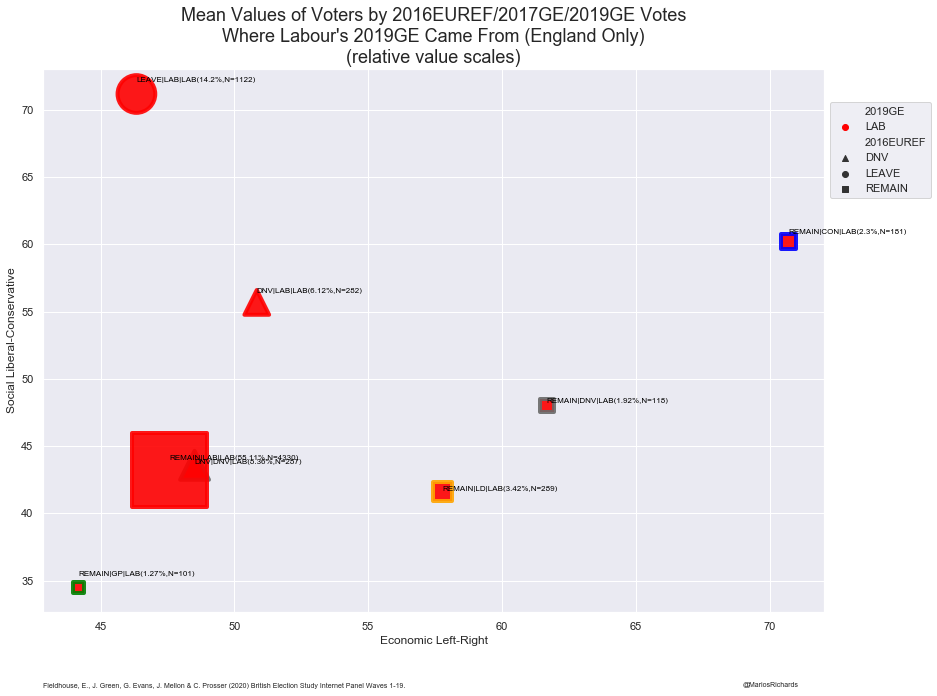

In [255]:
# %%time
# cat_variable = "profile_past_vote_2015"


# mask = BES_Panel["profile_eurefvote"].notnull() & BES_Panel["profile_past_vote_2017"].notnull() & BES_Panel["euroElectionVoteW16"].notnull()
# cats = BES_Panel["profile_eurefvote"].map(replace_dict).astype(str)+"|"+BES_Panel["profile_past_vote_2017"].map(replace_dict).astype(str)+"|"+BES_Panel["euroElectionVoteW16"].map(replace_dict).astype(str)
# cats[~mask] = np.nan
# cats = cats.astype('category')

# # cats = BES_Panel[cat_variable]
# cat_sample_sizes = cats.value_counts()

# cats.cat.remove_categories(cat_sample_sizes[cat_sample_sizes<200].index,inplace=True)

# cats = cats.apply(lambda x: x+"(N="+str(cat_sample_sizes.loc[x])+")")


title = "Mean Values of Voters by 2016EUREF/2017GE/2019GE-VI\n(England Only)\n(Normalised Political Compass)\n(Voronoi Overlap)"
# fig = plt.figure(figsize=(14,10))
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)

restriction = (BES_Panel["countryW19"]=="English") & (BES_Panel["pastvote_ge_2019W19"]=="Labour")
# restriction = None
sample_size_boost=100
min_sample_size = 100

BES = BES_Panel
if restriction is None:
#     BES = BES_Panel
    specific_mask = 1
else:
#     BES = BES_Panel[restriction]
    specific_mask = restriction
# BES = BES_Panel

var_list = ["profile_eurefvote","profile_past_vote_2017","pastvote_ge_2019W19"]
exposed_final_vote_name = "2019GE-VI"


best_weight_variable = 'wt_new_W19_result'
wts = BES_Panel[best_weight_variable].copy()
if restriction is not None:
    wts[~specific_mask] = np.nan


mask = BES[var_list].notnull().all(axis=1) & specific_mask
cats = BES[var_list].apply(lambda x: x.map(replace_dict)).astype(str).apply(lambda x: "|".join(x),axis=1)
# mask = BES_Panel["profile_eurefvote"].notnull() & BES_Panel["profile_past_vote_2017"].notnull() & BES_Panel["euroElectionVoteW16"].notnull()
# cats = BES_Panel["profile_eurefvote"].map(replace_dict).astype(str)+"|"+BES_Panel["profile_past_vote_2017"].map(replace_dict).astype(str)+"|"+BES_Panel["euroElectionVoteW16"].map(replace_dict).astype(str)
cats[~mask] = np.nan
cats = cats.astype('category')

# cats = BES_Panel[cat_variable]
cat_sample_sizes = cats.value_counts()
weighted_perc = round(weighted_value_counts(cats,wts,normalize=True, perc=True)["weighted_sample_percentage"],2).apply(lambda x: str(x) +"%"  )

cats.cat.remove_categories(cat_sample_sizes[cat_sample_sizes<min_sample_size].index,inplace=True)

cats = cats.apply(lambda x: x+"("+weighted_perc.loc[x]+",N="+str(cat_sample_sizes.loc[x])+")")


# cats = cats.apply(lambda x: x if x in cat_sample_sizes[cat_sample_sizes>500].index else np.nan).astype('category')

best_al_scale_variable = search(BES_Panel,"al_scale",mask=cats.notnull()).sort_values(ascending=False).index[0]
best_lr_scale_variable = search(BES_Panel,"lr_scale",mask=cats.notnull()).sort_values(ascending=False).index[0]

# best_weight_variable = search(BES_Panel,"wt_",mask=BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan).notnull()).sort_values(ascending=False).index[0]


al_mask = BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan).notnull() & wts.notnull() & mask
euro_election_al = pd.crosstab(index   = cats,
                       columns = weighted_qcut(BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan)[al_mask],
                                               wts[al_mask],100).cat.codes,
                       values  = wts[al_mask],
                       aggfunc = sum,
                       normalize='index')
euro_election_al = euro_election_al.apply(lambda x: sum(x*euro_election_al.columns),axis=1)
lr_mask = BES_Panel[best_lr_scale_variable].cat.codes.replace(-1,np.nan).notnull() & wts.notnull()&mask
euro_election_lr = pd.crosstab(index   = cats,
                       columns = weighted_qcut(BES_Panel[best_lr_scale_variable].cat.codes.replace(-1,np.nan)[lr_mask],
                                               wts[lr_mask],100).cat.codes,
                       values  = wts[lr_mask],
                       aggfunc = sum,
                       normalize='index')
euro_election_lr = euro_election_lr.apply(lambda x: sum(x*euro_election_lr.columns),axis=1)

# euro_election_al = BES_Panel[best_al_scale_variable].cat.codes.replace(-1,np.nan).groupby(cats).mean()
# euro_election_lr = BES_Panel[best_lr_scale_variable].cat.codes.replace(-1,np.nan).groupby(cats).mean()

df = pd.concat([euro_election_lr,euro_election_al],axis=1).reset_index()
cat_name ="2016EUREF|2017GE|2019GE"
lr_scale_name = "Economic Left-Right"
al_scale_name = "Social Liberal-Conservative"
df.columns = [cat_name,lr_scale_name,al_scale_name]

df["2016EUREF"] = df[cat_name].apply(lambda x: x.split("|")[0])
df["2017GE"] = df[cat_name].apply(lambda x: x.split("|")[1])
df["2019GE"] = df[cat_name].apply(lambda x: x.split("|")[2].split("(")[0])
df["sample_size"] = df[cat_name].apply(lambda x: int(x.split("|")[2].split("=")[1].split(")")[0]) )
df["wt_sample_perc"] = df[cat_name].apply(lambda x: float(x.split("|")[2].split("(")[1].split("%")[0]) ).astype('float')

# df = df.drop(0)
from itertools import cycle
filled_markers = cycle(['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X'])
# plt.figure(figsize=(14,10))
sct = sns.scatterplot(data=df,x=lr_scale_name,y=al_scale_name, 
                hue="2019GE" ,palette = colourmap,style="2016EUREF", markers = ['^','o','s','D'],
                linewidth=4,edgecolor = df["2017GE"].map(colourmap), s = df["wt_sample_perc"]*sample_size_boost,
                alpha=.9)
#                 label=df[cat_name])
# s=1000,                
                
#                 style=cat_name,
#                 markers=filled_markers);
#                 size="size");
plt.title("Mean Values of Voters by 2016EUREF/2017GE/2019GE Votes\nWhere Labour's 2019GE Came From (England Only)\n(relative value scales)", fontsize=18);

for line in range(0,df.shape[0]):
     sct.text(df[lr_scale_name][line]-0.01, df[al_scale_name][line]+np.random.rand(), 
     df[cat_name][line], horizontalalignment='left', 
     size=8, color='black')#, weight='semibold')

plt.legend(loc='center left', bbox_to_anchor=(1, .85))        
# lgnd = plt.legend(title='Smoker', loc='upper left')
# lgnd.legendHandles[0]._sizes = [30]
# lgnd.legendHandles[1]._sizes = [30]
# plt.show()
# plt.gca().legend()
sct.annotate(dataset_citation, (0,0), (0, -70),
                 xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ; 
sct.annotate("@MariosRichards", (0,0), (700, -70),
                 xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ; 

In [227]:
df["wt_sample_perc"]*sample_size_boost

0      8.0
1      0.0
2      1.0
3      1.0
4      1.0
      ... 
267    0.0
268    1.0
269    0.0
270    2.0
271    0.0
Name: wt_sample_perc, Length: 272, dtype: float64

In [231]:
df.set_index(cat_name).loc['REMAIN|LD|DK(0.01%,N=2)']

Economic Left-Right                10
Social Liberal-Conservative        88
2016EUREF                      REMAIN
2017GE                             LD
2019GE                             DK
sample_size                         2
wt_sample_perc                   0.01
Name: REMAIN|LD|DK(0.01%,N=2), dtype: object

In [230]:
[x for x in df.set_index(cat_name).index if "REMAIN|LD|DK" in x]

['REMAIN|LD|DK(0.01%,N=2)']

In [237]:
weighted_value_counts(cats,BES_Panel["wt_new_W19_result"],normalize=True,perc=True,).sum()

weighted_sample_percentage      25.46
raw_sample_size               8506.00
dtype: float64

In [239]:
round(weighted_value_counts(cats,BES_Panel["wt_new_W19_result"],normalize=True, perc=True)["weighted_sample_percentage"],2).apply(lambda x: str(x) +"%"  )

value
DNV|LAB|GP(0.04%,N=14)            0.04%
DK|LAB|LAB(0.1%,N=27)              0.1%
LEAVE|LAB|DK(0.1%,N=22)            0.1%
REMAIN|LAB|OTH(0.11%,N=56)        0.11%
LEAVE|LAB|OTH(0.12%,N=68)         0.12%
DNV|LAB|CON(0.13%,N=33)           0.13%
DNV|LAB|LD(0.14%,N=33)            0.14%
LEAVE|LAB|GP(0.16%,N=76)          0.16%
REMAIN|LAB|DK(0.16%,N=24)         0.16%
LEAVE|LAB|LD(0.28%,N=92)          0.28%
LEAVE|LAB|BXP(0.3%,N=134)          0.3%
REMAIN|LAB|GP(0.43%,N=199)        0.43%
REMAIN|LAB|CON(0.51%,N=167)       0.51%
REMAIN|LAB|DNV(0.71%,N=137)       0.71%
DNV|LAB|DNV(0.77%,N=114)          0.77%
LEAVE|LAB|DNV(0.97%,N=210)        0.97%
DNV|LAB|LAB(1.36%,N=282)          1.36%
REMAIN|LAB|LD(1.65%,N=631)        1.65%
LEAVE|LAB|CON(2.06%,N=735)        2.06%
LEAVE|LAB|LAB(3.15%,N=1122)       3.15%
REMAIN|LAB|LAB(12.21%,N=4330)    12.21%
Name: weighted_sample_percentage, dtype: object

In [238]:
cats

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
97153    NaN
97154    NaN
97155    NaN
97156    NaN
97157    NaN
Name: value, Length: 97158, dtype: category
Categories (21, object): [DK|LAB|LAB(0.1%,N=27), DNV|LAB|CON(0.13%,N=33), DNV|LAB|DNV(0.77%,N=114), DNV|LAB|GP(0.04%,N=14), ..., REMAIN|LAB|GP(0.43%,N=199), REMAIN|LAB|LAB(12.21%,N=4330), REMAIN|LAB|LD(1.65%,N=631), REMAIN|LAB|OTH(0.11%,N=56)]

In [52]:
(BES_Panel[BES_Panel[past_vote_var]=="Did not vote"]["Age"]<=23).value_counts()

# 3:1 

False    4991
True     1765
Name: Age, dtype: Int64

In [43]:
search(BES_Panel,"Citizen")

ukCitizenW1               30575
euCitizenW1               30575
commonwealthCitizenW1     30575
otherCitizenW1            30575
ukCitizenW8                6338
euCitizenW8                6338
commonwealthCitizenW8      6338
otherCitizenW8             6338
britCitizenW11            30956
ukCitizenW14              31063
euCitizenW14              31063
commonwealthCitizenW14    31063
otherCitizenW14           31063
ukCitizenW15              30842
euCitizenW15              30842
commonwealthCitizenW15    30842
otherCitizenW15           30842
ukCitizenW16              37959
euCitizenW16              37959
commonwealthCitizenW16    37959
otherCitizenW16           37959
ukCitizenW17               3564
euCitizenW17               3564
commonwealthCitizenW17     3564
otherCitizenW17            3564
dtype: int64

In [45]:
BES_Panel["ukCitizenW16"].value_counts()

Yes    37021
No       938
Name: ukCitizenW16, dtype: int64

In [46]:
BES_Panel["registeredW19"].value_counts()

Yes - at $postcode_hidden    31385
Yes - another address          351
Don't know                     259
No                             182
Name: registeredW19, dtype: int64